In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
from PIL import Image

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model, layers, callbacks, optimizers, losses
from tensorflow.keras.applications import ResNet50, resnet50, MobileNetV2, mobilenet_v2

from tqdm import tqdm
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

2024-07-11 20:01:12.999674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 20:01:12.999808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 20:01:13.133147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Collection

In [2]:
data_folder = "/kaggle/input/chest-xray-pneumonia"

def GetDf(data_folder):
    data = {"image_link": [], "image_class": []}
    for idx, i in enumerate(glob(data_folder+"/*/*/*/*.jpeg")):
        data["image_link"].append(i)
        data["image_class"].append(i.split("/")[-2])
    print("Data Loaded Sucessfully")
    return pd.DataFrame(data)

In [3]:
df = GetDf(data_folder)

Data Loaded Sucessfully


In [4]:
df.shape

(5856, 2)

In [5]:
df.head()

image_link image_class
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA

In [30]:
test = df[df["image_link"].str.contains("val")]

test

image_link image_class
0   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
1   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
2   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
3   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
4   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
5   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
6   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
7   /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
8   /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
9   /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
10  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
11  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
12  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
13  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
14  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
15  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL

In [36]:
df.drop(index=test.index, inplace=True)

In [38]:
df.reset_index(drop=True, inplace=True)

# EDA

In [39]:
def PlotTargetDist(df):
    target_distribution = df["image_class"].value_counts().plot(kind="bar", figsize=(15,5), xlabel="Label", ylabel="Counts", title="Target Distribution")

    for p in target_distribution.patches:
        h = p.get_height()
        target_distribution.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

    target_distribution.set_xticklabels(labels=target_distribution.get_xticklabels(), rotation=0)
    plt.show()

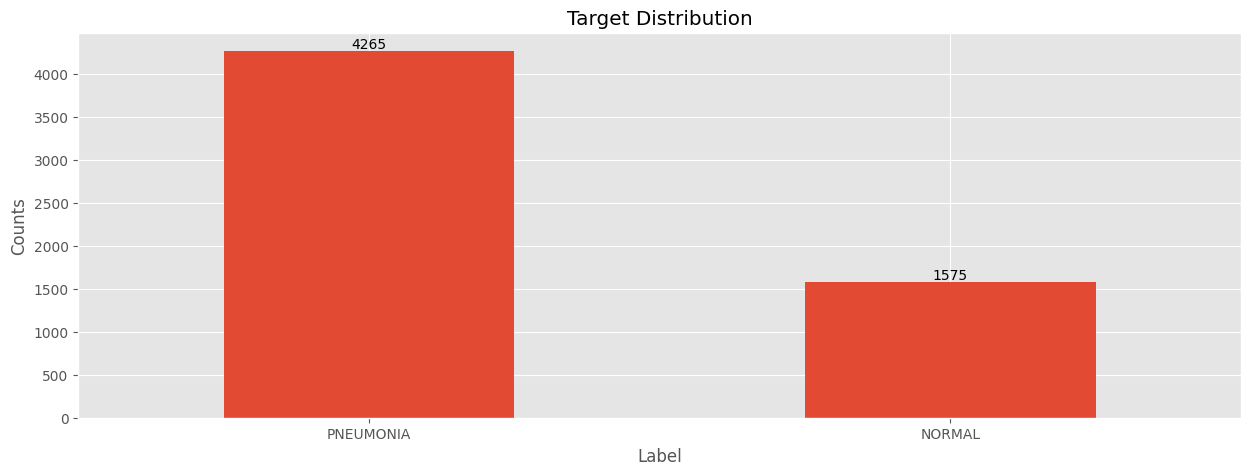

In [40]:
PlotTargetDist(df)

# Data Upsampling

In [41]:
def UpsampleData(X, y):
    upsampler = RandomOverSampler()
    Xup, yup = upsampler.fit_resample(X, y)
    return pd.DataFrame({"image_link":Xup.flatten(), "image_class":yup})

In [42]:
X = df["image_link"].to_numpy().reshape(-1, 1)
y = df["image_class"].to_numpy().reshape(-1, 1)

In [43]:
upsampled_data = UpsampleData(X, y)

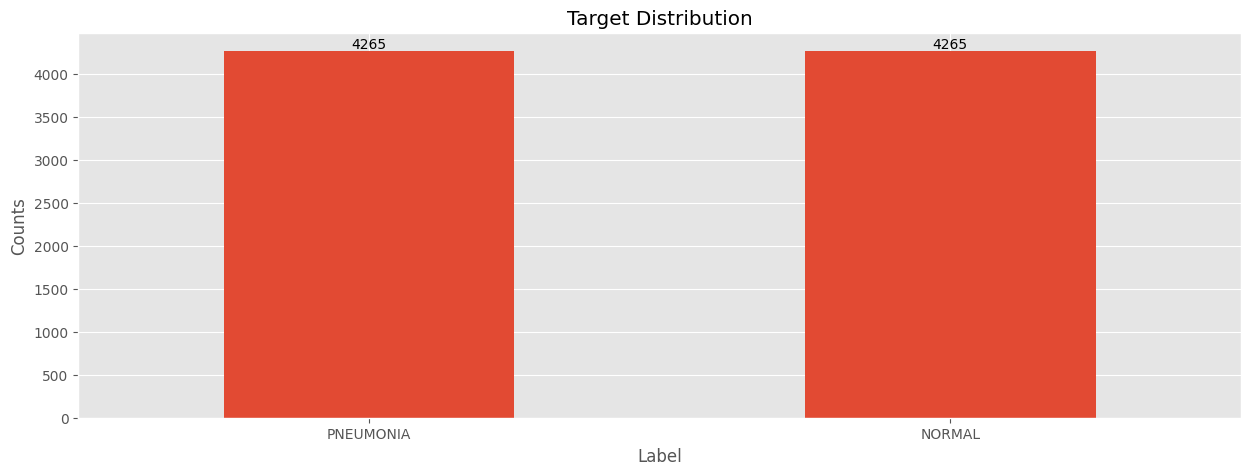

In [44]:
PlotTargetDist(upsampled_data)

In [45]:
X_up, y_up = upsampled_data["image_link"], upsampled_data["image_class"]

In [46]:
xtrain, xval, ytrain, yval = train_test_split(X_up, y_up, test_size=.1, random_state=42, stratify=y_up)

train = pd.concat([xtrain, ytrain], axis="columns").reset_index(drop=True)
val = pd.concat([xval, yval], axis="columns").reset_index(drop=True)

print(f"Training size: {train.shape}")
print(f"Validation size: {val.shape}")
print(f"Test size: {test.shape}")

Training size: (7677, 2)
Validation size: (853, 2)
Test size: (16, 2)


In [47]:
train

image_link image_class
0     /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
1     /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
2     /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
3     /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
4     /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
...                                                 ...         ...
7672  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
7673  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA
7674  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
7675  /kaggle/input/chest-xray-pneumonia/chest_xray/...      NORMAL
7676  /kaggle/input/chest-xray-pneumonia/chest_xray/...   PNEUMONIA

[7677 rows x 2 columns]

# TRAIN TARGET DISTRIBUTION

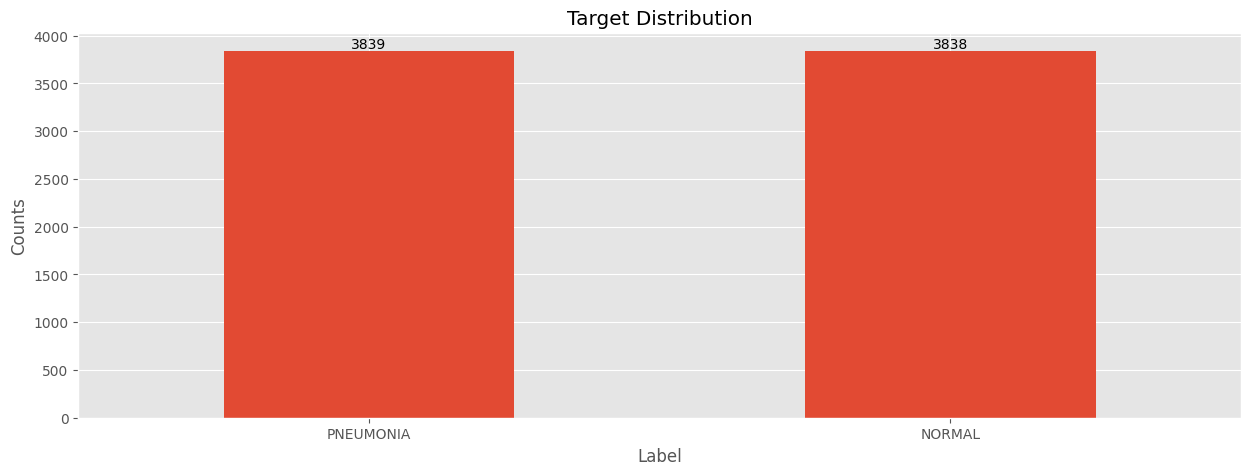

In [48]:
PlotTargetDist(train)

# Validation Target Distribution

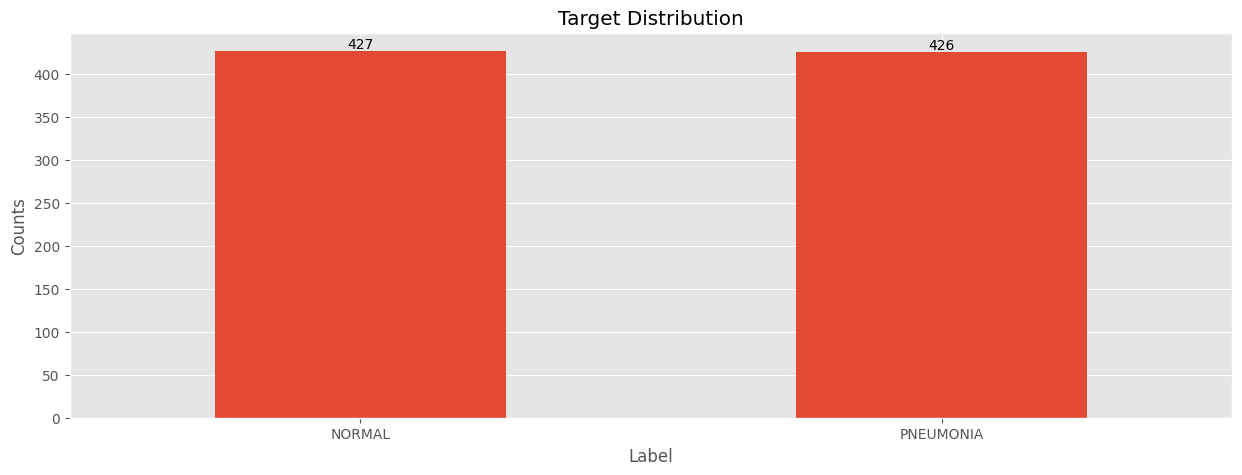

In [49]:
PlotTargetDist(val)

In [50]:
def DisplayImage(df):
    random_index = np.random.randint(low=0, high=df.shape[0], size=9)

    plt.figure(figsize=(13, 13))
    for index, r_i in enumerate(random_index):
        img_lbl = df.loc[r_i, "image_class"]
        img_lnk = np.expand_dims(np.array(Image.open(df.loc[r_i, "image_link"]).convert("L").resize((224, 224))), axis=-1)

        plt.subplot(3, 3, index+1)
        plt.imshow(img_lnk, cmap="gray")
        plt.title(img_lbl)
        plt.axis(False)

    plt.tight_layout()
    plt.show()

# Train Samples

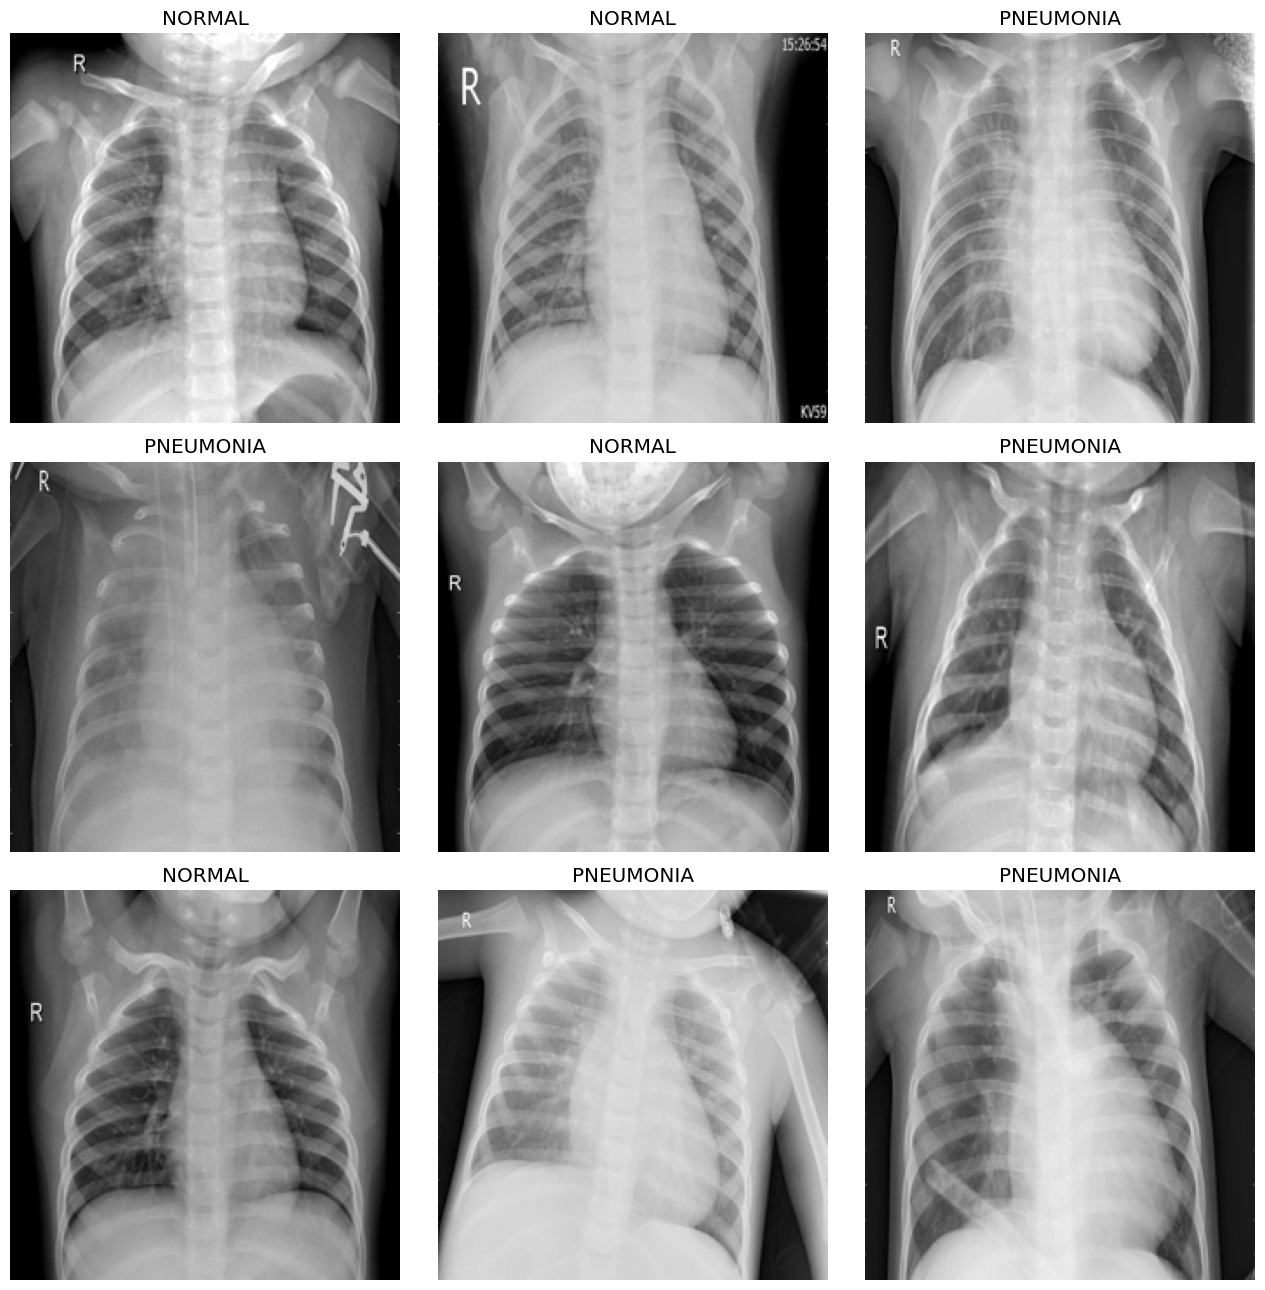

In [51]:
DisplayImage(train)

# Validation samples

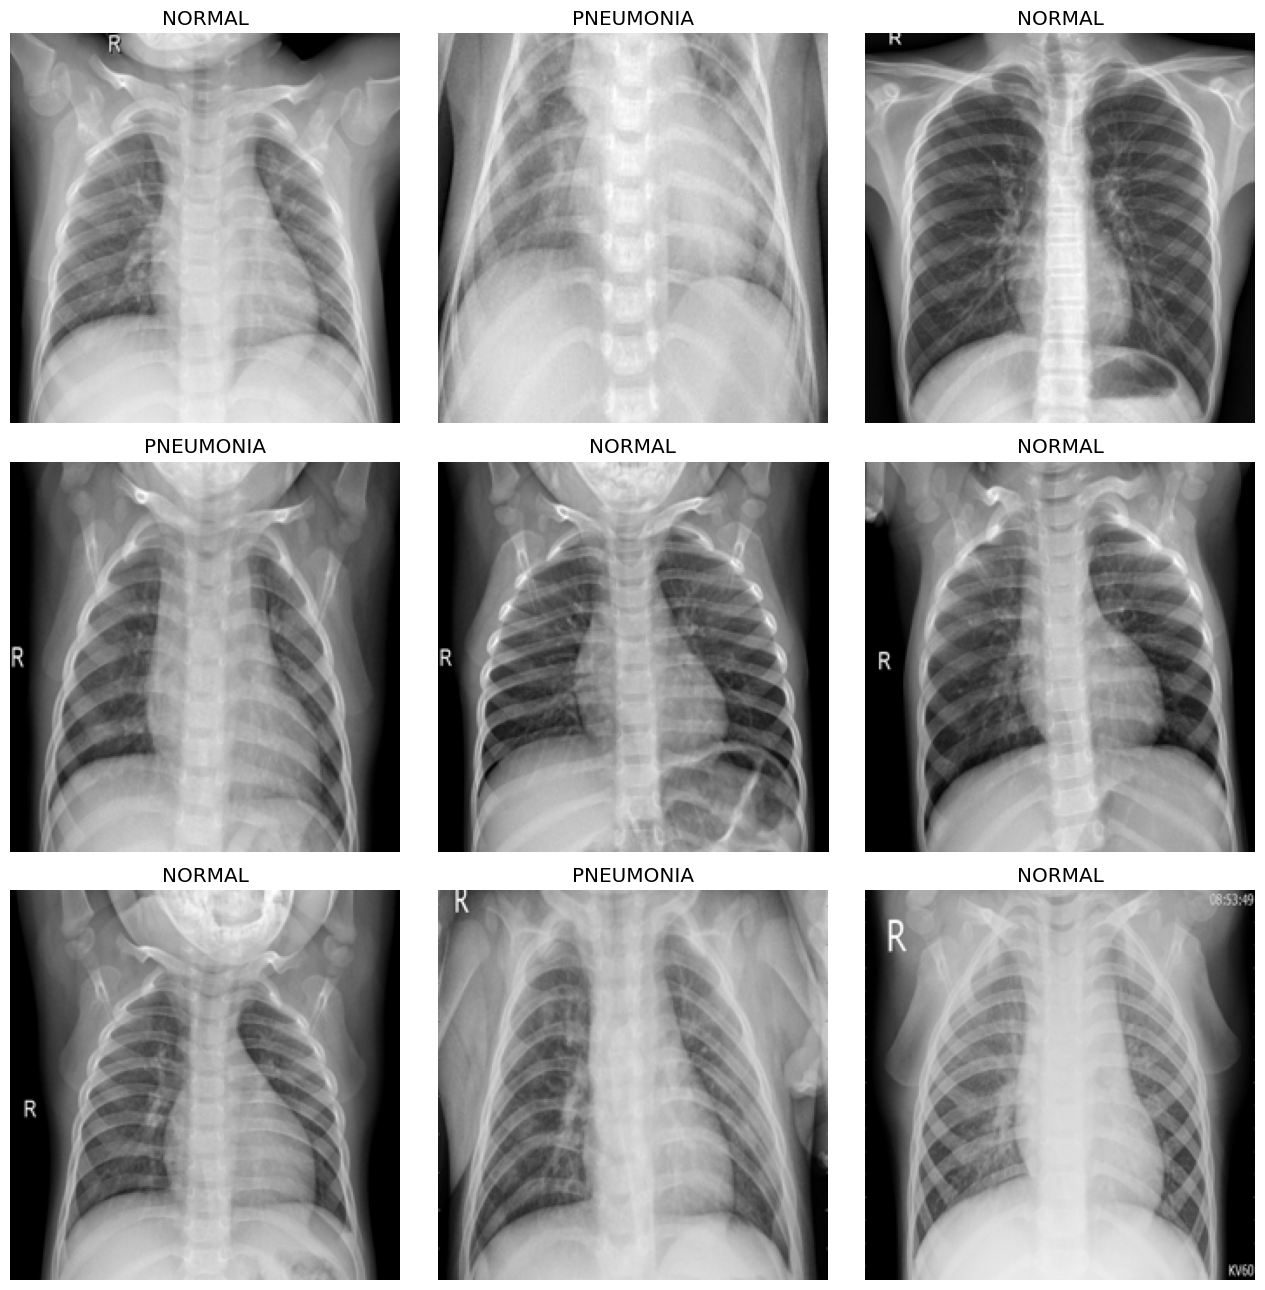

In [53]:
DisplayImage(val)

# Test Samples

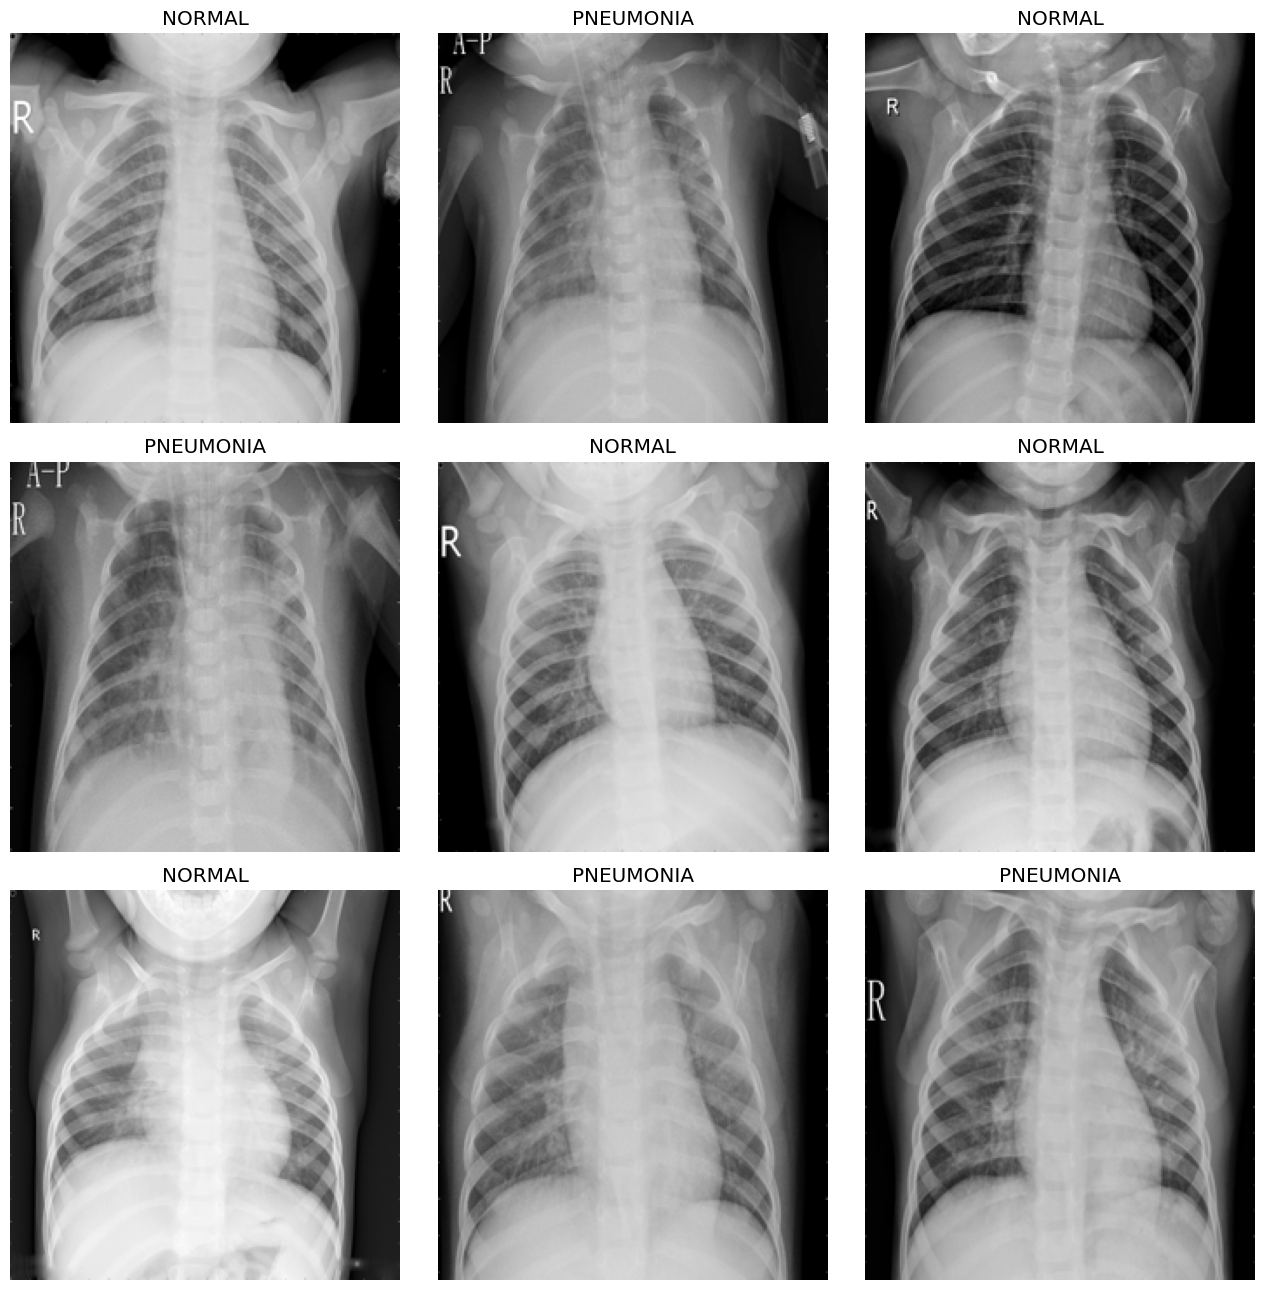

In [54]:
DisplayImage(test)

# Data preparation

In [58]:
train_gen = ImageDataGenerator(rescale=1/255)
test_and_val_gen = ImageDataGenerator(rescale=1/255)

In [59]:
train_data_gen = train_gen.flow_from_dataframe(train,
                                               x_col="image_link",
                                               y_col="image_class",
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               class_mode="binary")

val_data_gen = test_and_val_gen.flow_from_dataframe(val,
                                                    x_col="image_link",
                                                    y_col="image_class",
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode="binary")

test_data_gen = test_and_val_gen.flow_from_dataframe(test,
                                                     x_col="image_link",
                                                     y_col="image_class",
                                                     color_mode='rgb',
                                                     target_size=(224, 224),
                                                     class_mode="binary")

Found 7677 validated image filenames belonging to 2 classes.
Found 853 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [60]:
batch_x, batch_y = next(train_data_gen)

batch_x.shape

(32, 224, 224, 3)

In [61]:
batch_x, batch_y

(array([[[[0.27450982, 0.27450982, 0.27450982],
          [0.3019608 , 0.3019608 , 0.3019608 ],
          [0.5411765 , 0.5411765 , 0.5411765 ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.28627452, 0.28627452, 0.28627452],
          [0.2784314 , 0.2784314 , 0.2784314 ],
          [0.47450984, 0.47450984, 0.47450984],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.2784314 , 0.2784314 , 0.2784314 ],
          [0.26666668, 0.26666668, 0.26666668],
          [0.34117648, 0.34117648, 0.34117648],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# Modelling

In [62]:
def create_cnn_model(input_shape=batch_x.shape[1:], num_classes=1):
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

base_model = create_cnn_model(input_shape=batch_x.shape[1:], num_classes=1)

base_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,210,625 (99.99 MB)

 Trainable params: 26,210,625 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
base_model.compile(loss=losses.BinaryCrossentropy(),
                   optimizer=optimizers.RMSprop(learning_rate=0.001),
                   metrics=['accuracy'])

In [65]:
base_history = base_model.fit(train_data_gen,
                              validation_data=val_data_gen,
                              batch_size=64,
                              callbacks=[callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                                         callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.1)],
                              epochs=20)

Epoch 1/20
  9/240 ━━━━━━━━━━━━━━━━━━━━ 1:02 270ms/step - accuracy: 0.4972 - loss: 1.1567

2024-07-11 20:14:45.929519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 2.49604, expected 2.14495
2024-07-11 20:14:45.929584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.15854, expected 1.80744
2024-07-11 20:14:45.929594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50399: 2.42816, expected 2.07706
2024-07-11 20:14:45.929877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.0471, expected 3.14405
2024-07-11 20:14:45.929916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.33106, expected 5.42801
2024-07-11 20:14:45.929928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.60423, expected 5.70118
2024-07-11 20:14:45.929940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.66687, expected 5.76382
2024-07-11 20:14:45.9299

239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7571 - loss: 0.5379

2024-07-11 20:16:17.675947: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.46258, expected 2.94933
2024-07-11 20:16:17.675999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.2795, expected 2.76625
2024-07-11 20:16:17.676008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.27276, expected 2.75951
2024-07-11 20:16:17.676016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.77959, expected 3.26634
2024-07-11 20:16:17.676024: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 3.34271, expected 2.82946
2024-07-11 20:16:17.676031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65: 3.77258, expected 3.25933
2024-07-11 20:16:17.676039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 67: 3.46412, expected 2.95087
2024-07-11 20:16:17.676047: E external/local_xla/x

240/240 ━━━━━━━━━━━━━━━━━━━━ 105s 409ms/step - accuracy: 0.7578 - loss: 0.5367 - val_accuracy: 0.9121 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 92s 373ms/step - accuracy: 0.9201 - loss: 0.2251 - val_accuracy: 0.9379 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 89s 361ms/step - accuracy: 0.9415 - loss: 0.1630 - val_accuracy: 0.9273 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 90s 367ms/step - accuracy: 0.9465 - loss: 0.1392 - val_accuracy: 0.9590 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 90s 366ms/step - accuracy: 0.9606 - loss: 0.1113 - val_accuracy: 0.9273 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 90s 364ms/step - accuracy: 0.9766 - loss: 0.0639 - val_accuracy: 0.9730 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 90s 366ms/step - accuracy: 0.9839 - 

In [67]:
base_history_df = pd.DataFrame(base_history.history)

base_history_df

accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.842517  0.389510      0.912075  0.302119   1.000000e-03
1   0.921584  0.213992      0.937866  0.174893   1.000000e-03
2   0.937215  0.173077      0.927315  0.282201   1.000000e-03
3   0.950241  0.131971      0.958968  0.253413   1.000000e-03
4   0.958187  0.112877      0.927315  0.305880   1.000000e-03
5   0.979419  0.054168      0.973036  0.191239   1.000000e-04
6   0.983978  0.040588      0.971864  0.363181   1.000000e-04
7   0.988277  0.030241      0.976553  0.166960   1.000000e-04
8   0.991273  0.024941      0.977726  0.335199   1.000000e-04
9   0.992184  0.022646      0.974209  0.390711   1.000000e-04
10  0.992966  0.017526      0.971864  0.603873   1.000000e-04
11  0.996353  0.011470      0.973036  0.387430   1.000000e-05
12  0.996092  0.012088      0.975381  0.277856   1.000000e-05
13  0.995311  0.012680      0.971864  0.484502   1.000000e-05
14  0.995962  0.010611      0.978898  0.313578   1.000000e-06
15  0.995832  0.011929      0.971864  0.393951   1.000000e-06
16  0.996222  0.011462      0.975381  0.468012   1.000000e-06
17  0.996353  0.010569      0.976553  0.345437   1.000000e-07

In [68]:
def ModelEvaluation(df):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))
    ax = ax.flatten()
    df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
    ax[0].set_title("Model accuracy comparison")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    df[["loss", "val_loss"]].plot(ax=ax[1])
    ax[1].set_title("Model loss comparison")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")


    plt.tight_layout()
    plt.show()

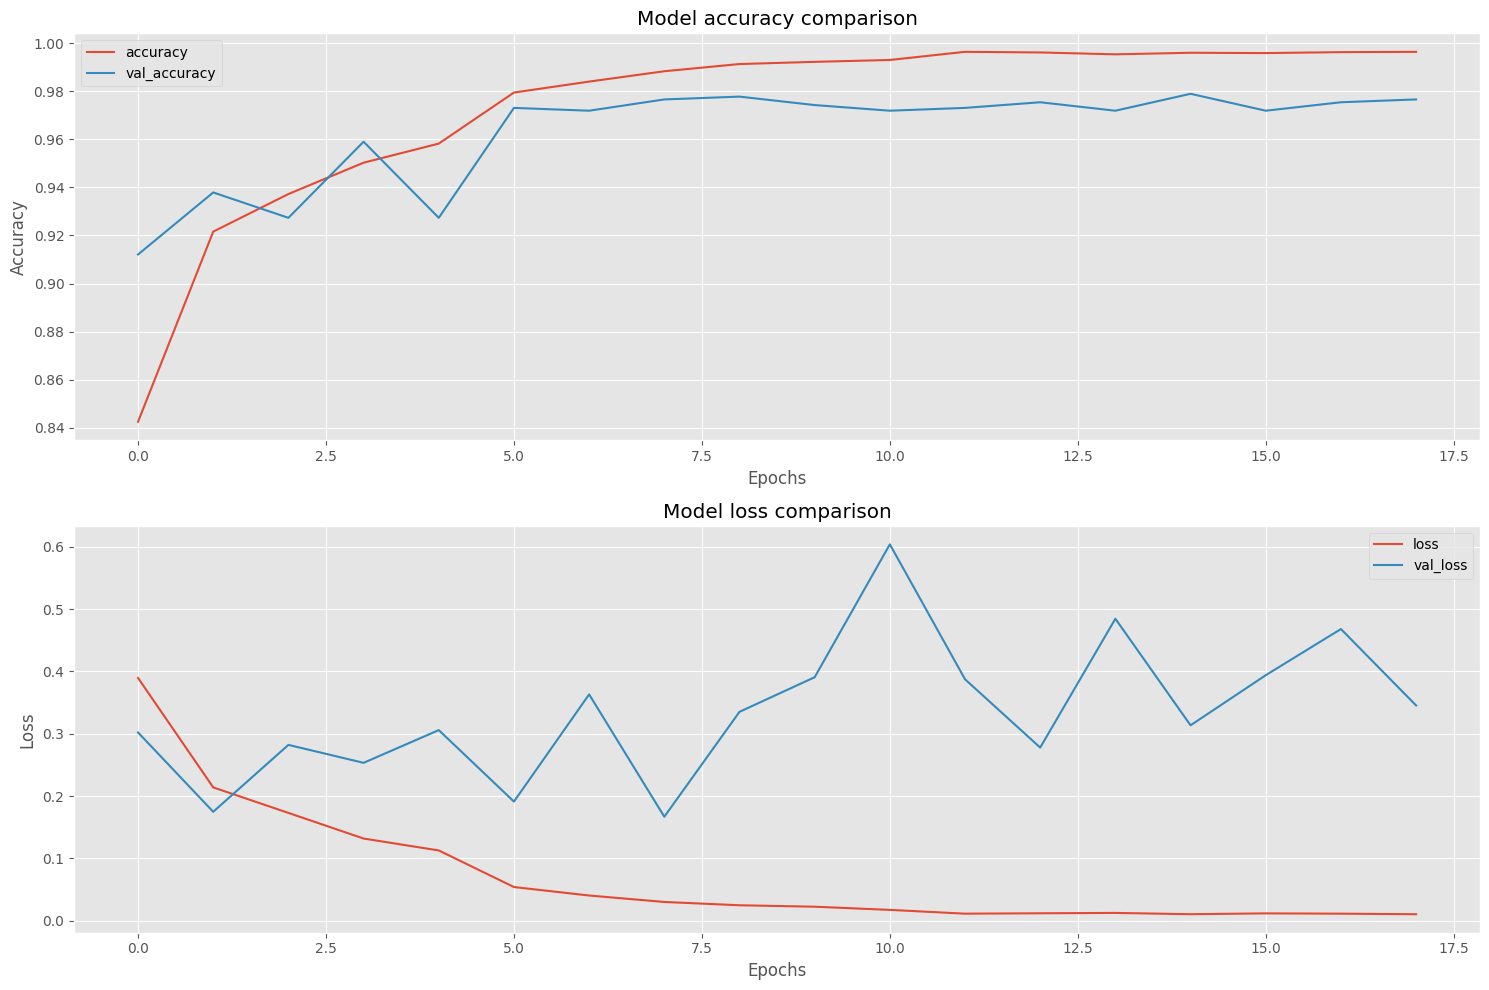

In [69]:
ModelEvaluation(base_history_df)

In [70]:
def ModelEvaluationOnTestSet(data_gen, model):
    test_pred_from_base_model = np.round(model.predict(data_gen)).flatten()
    y_true = np.array(data_gen.classes)

    def plot_roc_curve(y_true, y_pred_probs):
        """
        Plot the ROC curve for binary classification.

        Parameters:
        y_true (array-like): True binary labels.
        y_pred_probs (array-like): Predicted probabilities for the positive class.
        """
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

        # Compute the area under the ROC curve
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

    print("Classification Report:\n", classification_report(y_true, test_pred_from_base_model))

    plot_roc_curve(y_true, test_pred_from_base_model)

2024-07-11 20:42:46.524023: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100575: 1.87379, expected 1.57926
2024-07-11 20:42:46.524457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150528: 3.95832, expected 3.44133
2024-07-11 20:42:46.524496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150534: 4.15218, expected 3.63519
2024-07-11 20:42:46.524510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150535: 4.02956, expected 3.51257
2024-07-11 20:42:46.524527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150536: 3.63562, expected 3.11863
2024-07-11 20:42:46.524541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150538: 3.86037, expected 3.34338
2024-07-11 20:42:46.524552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150539: 3.47832, expected 2.96133
2024-07-11 20:42:46.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.38      0.38      0.38         8

    accuracy                           0.38        16
   macro avg       0.38      0.38      0.38        16
weighted avg       0.38      0.38      0.38        16



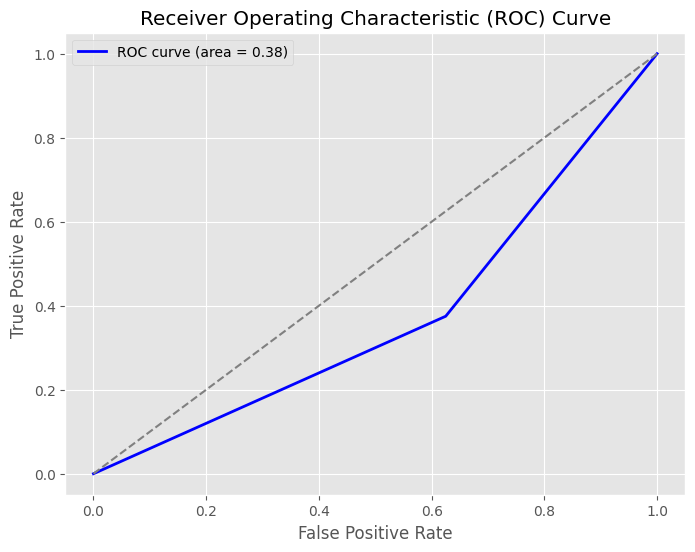

In [71]:
ModelEvaluationOnTestSet(test_data_gen, base_model)

# Data Augmentation

In [73]:
train_gen_aug = ImageDataGenerator(
                                rescale=1/255,
                                horizontal_flip=True,
                                rotation_range=15,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=[0.8, 1.2]
                            )

In [77]:
train_data_gen_aug = train_gen_aug.flow_from_dataframe(train,
                                                       x_col="image_link",
                                                       y_col="image_class",
                                                       color_mode='rgb',
                                                       target_size=(224, 224),
                                                       class_mode="binary")

Found 7677 validated image filenames belonging to 2 classes.


In [74]:
base_model = create_cnn_model(input_shape=batch_x.shape[1:], num_classes=1)

base_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,210,625 (99.99 MB)

 Trainable params: 26,210,625 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
base_model.compile(loss=losses.BinaryCrossentropy(),
                   optimizer=optimizers.RMSprop(learning_rate=0.001),
                   metrics=['accuracy'])

In [78]:
base_history = base_model.fit(train_data_gen_aug,
                              validation_data=val_data_gen,
                              batch_size=64,
                              callbacks=[callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                                         callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.1)],
                              epochs=20)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 176s 694ms/step - accuracy: 0.6046 - loss: 0.8468 - val_accuracy: 0.7984 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 169s 684ms/step - accuracy: 0.8215 - loss: 0.4535 - val_accuracy: 0.7034 - val_loss: 2.1028 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 168s 681ms/step - accuracy: 0.8513 - loss: 0.3736 - val_accuracy: 0.8921 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 168s 682ms/step - accuracy: 0.8773 - loss: 0.3262 - val_accuracy: 0.9039 - val_loss: 2.4927 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 169s 684ms/step - accuracy: 0.9194 - loss: 0.2210 - val_accuracy: 0.9250 - val_loss: 2.6824 - learning_rate: 1.0000e-04
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 169s 685ms/step - accuracy: 0.9221 - loss: 0.2014 - val_accuracy: 0.9308 - val_loss: 2.2441 - learning_rate: 1.0000e-04
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 169s 683ms/step 

In [79]:
base_history_df = pd.DataFrame(base_history.history)

base_history_df

accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.703139  0.646398      0.798359  0.978451       0.001000
1   0.826625  0.437285      0.703400  2.102811       0.001000
2   0.871304  0.327949      0.892145  1.070133       0.001000
3   0.884721  0.307326      0.903869  2.492717       0.001000
4   0.922105  0.220165      0.924971  2.682429       0.000100
5   0.924710  0.201405      0.930832  2.244096       0.000100
6   0.930442  0.191709      0.930832  1.638095       0.000100
7   0.931353  0.190750      0.928488  2.309370       0.000010
8   0.931223  0.192082      0.930832  2.599368       0.000010
9   0.931093  0.190566      0.941383  1.821126       0.000010
10  0.930702  0.186134      0.933177  2.307050       0.000001

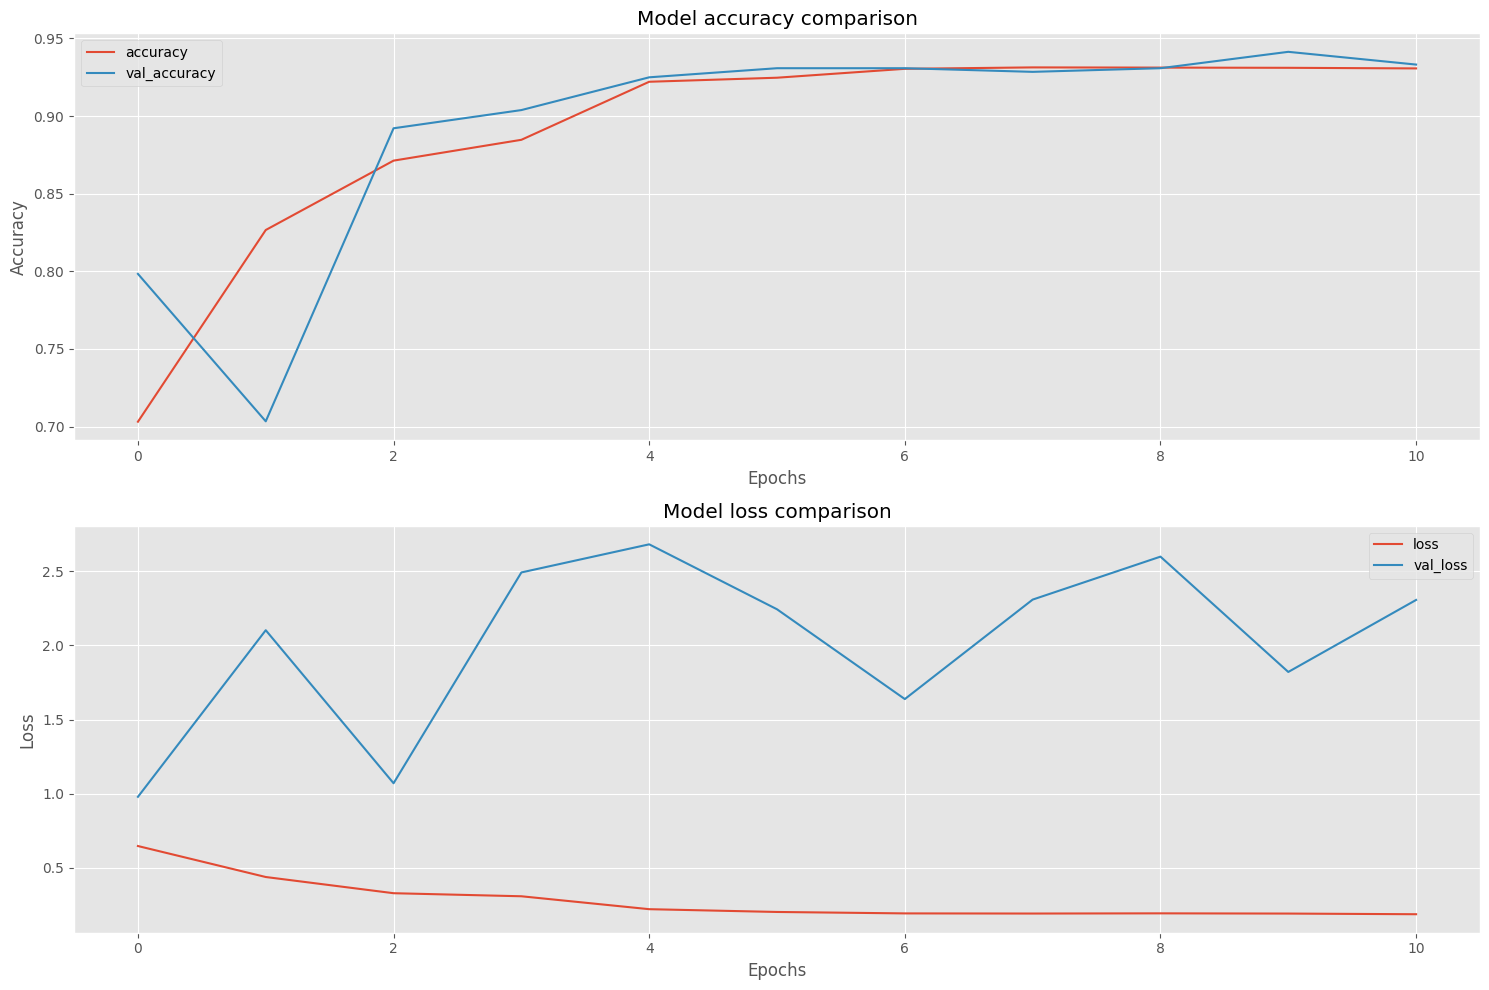

In [80]:
ModelEvaluation(base_history_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



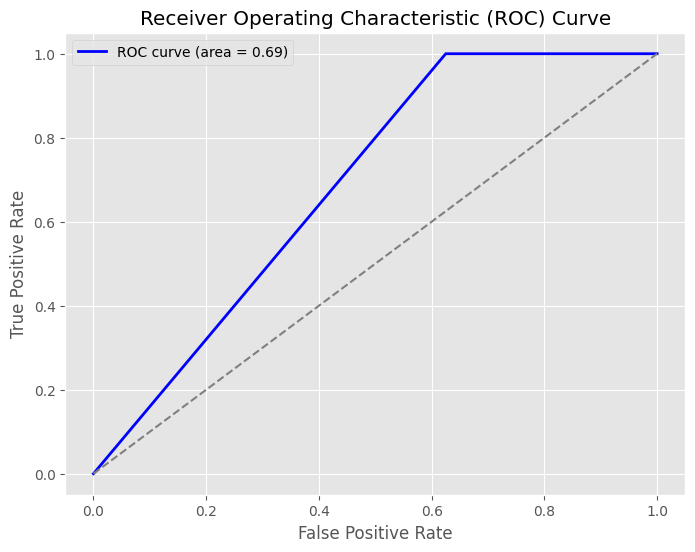

In [81]:
ModelEvaluationOnTestSet(test_data_gen, base_model)

# ResNet50

In [82]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=batch_x.shape[1:])

# Freeze the base model layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add custom top layers
x = base_model_resnet.output
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Define the model
resnet_model = Model(inputs=base_model_resnet.input, outputs=output_layer)

# Print model summary
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [83]:
train_gen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_and_val_gen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)


train_data_gen = train_gen.flow_from_dataframe(train,
                                               x_col="image_link",
                                               y_col="image_class",
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               class_mode="binary")

val_data_gen = test_and_val_gen.flow_from_dataframe(val,
                                                    x_col="image_link",
                                                    y_col="image_class",
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode="binary")

test_data_gen = test_and_val_gen.flow_from_dataframe(test,
                                                     x_col="image_link",
                                                     y_col="image_class",
                                                     color_mode='rgb',
                                                     target_size=(224, 224),
                                                     class_mode="binary")

Found 7677 validated image filenames belonging to 2 classes.
Found 853 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [84]:
resnet_model.compile(loss=losses.BinaryCrossentropy(),
                     optimizer=optimizers.RMSprop(learning_rate=0.001),
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_gen,
                                  validation_data=val_data_gen,
                                  batch_size=64,
                                  callbacks=[callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                                           callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.1)],
                                  epochs=20)

Epoch 1/20
104/240 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.7840 - loss: 0.4756

In [35]:
resnet_history_df = pd.DataFrame(resnet_history.history)

resnet_history_df

loss  accuracy  val_loss  val_accuracy        lr
0   0.487003  0.860445  0.261873      0.899854  0.001000
1   0.205555  0.928028  0.164076      0.947368  0.001000
2   0.166224  0.942803  0.154772      0.945906  0.001000
3   0.164322  0.946606  0.155368      0.934942  0.001000
4   0.147534  0.949824  0.141010      0.940058  0.001000
5   0.132199  0.955091  0.120479      0.958333  0.001000
6   0.128613  0.959187  0.106401      0.965643  0.001000
7   0.119800  0.960211  0.100325      0.965643  0.001000
8   0.110922  0.962112  0.114508      0.967836  0.001000
9   0.104202  0.962844  0.088006      0.970029  0.001000
10  0.101765  0.966501  0.130087      0.968567  0.001000
11  0.092213  0.966940  0.122739      0.966374  0.001000
12  0.093516  0.970012  0.105594      0.967105  0.001000
13  0.062923  0.977765  0.091425      0.971491  0.000100
14  0.052522  0.983616  0.102232      0.971491  0.000100
15  0.045423  0.984055  0.101978      0.971491  0.000100
16  0.046239  0.985079  0.102496      0.970760  0.000010
17  0.043994  0.983177  0.104540      0.970029  0.000010
18  0.042321  0.983616  0.104827      0.970760  0.000010
19  0.041027  0.986834  0.105056      0.970760  0.000001

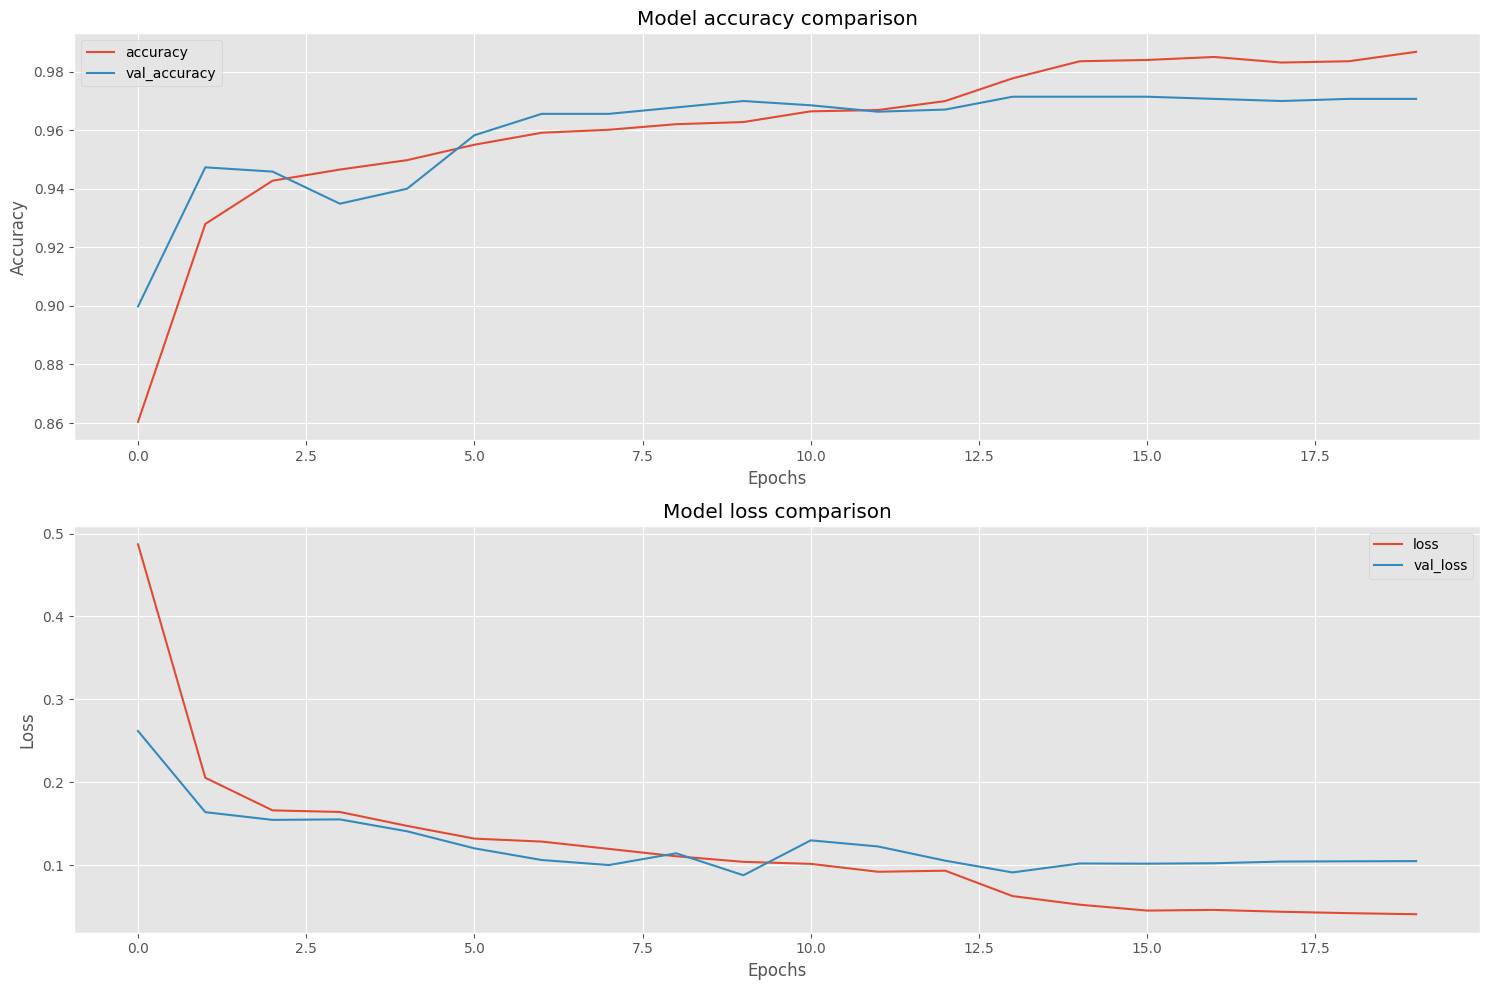

In [36]:
ModelEvaluation(resnet_history_df)

11/11 [==============================] - 7s 525ms/step

Classification Report:

               precision    recall  f1-score   support



           0       0.50      0.51      0.50       171

           1       0.50      0.49      0.50       171



    accuracy                           0.50       342

   macro avg       0.50      0.50      0.50       342

weighted avg       0.50      0.50      0.50       342




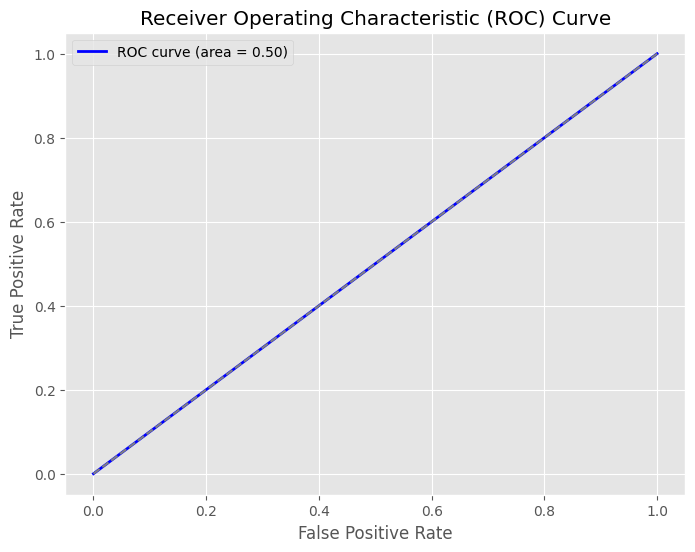

In [37]:
ModelEvaluationOnTestSet(test_data_gen, resnet_model)

# Fine Tuning Resnet50

In [40]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=batch_x.shape[1:])

# Freeze the base model layers
for layer in base_model_resnet.layers:
    layer.trainable = False
# Unfreeze BatchNormalization layers
for layer in base_model_resnet.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Add custom top layers
x = base_model_resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Define the model
resnet_model_fine_tuned = Model(inputs=base_model_resnet.input, outputs=output_layer)

# Print model summary
resnet_model_fine_tuned.summary()

Model: "model_2"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            

                                                                                                  

 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             

                                                                                                  

 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           

                                                                                                  

 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          

 on)                                                                             

In [42]:
resnet_model_fine_tuned.compile(loss=losses.BinaryCrossentropy(),
                                optimizer=optimizers.RMSprop(learning_rate=0.001),
                                metrics=['accuracy'])

In [43]:
resnet_finetune_history = resnet_model_fine_tuned.fit(train_data_gen,
                                                      validation_data=val_data_gen,
                                                      batch_size=64,
                                                      callbacks=[callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                                                                 callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.1)],
                                                       epochs=20)

Epoch 1/20

214/214 [==============================] - 154s 654ms/step - loss: 0.3869 - accuracy: 0.8833 - val_loss: 0.2980 - val_accuracy: 0.8699 - lr: 0.0010

Epoch 2/20

214/214 [==============================] - 114s 532ms/step - loss: 0.1456 - accuracy: 0.9506 - val_loss: 0.2935 - val_accuracy: 0.8911 - lr: 0.0010

Epoch 3/20

214/214 [==============================] - 113s 528ms/step - loss: 0.1057 - accuracy: 0.9678 - val_loss: 0.1267 - val_accuracy: 0.9605 - lr: 0.0010

Epoch 4/20

214/214 [==============================] - 114s 532ms/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.0930 - val_accuracy: 0.9795 - lr: 0.0010

Epoch 5/20

214/214 [==============================] - 114s 531ms/step - loss: 0.0731 - accuracy: 0.9804 - val_loss: 0.0879 - val_accuracy: 0.9817 - lr: 0.0010

Epoch 6/20

214/214 [==============================] - 117s 546ms/step - loss: 0.0574 - accuracy: 0.9836 - val_loss: 0.0788 - val_accuracy: 0.9839 - lr: 0.0010

Epoch 7/20

214/214 [=============

In [44]:
resnet_finetune_history_df = pd.DataFrame(resnet_finetune_history.history)

resnet_finetune_history_df

loss  accuracy  val_loss  val_accuracy        lr
0   0.386941  0.883265  0.298008      0.869883  0.001000
1   0.145644  0.950556  0.293504      0.891082  0.001000
2   0.105683  0.967817  0.126708      0.960526  0.001000
3   0.066338  0.980983  0.092987      0.979532  0.001000
4   0.073064  0.980398  0.087881      0.981725  0.001000
5   0.057401  0.983616  0.078777      0.983918  0.001000
6   0.036016  0.990638  0.561106      0.922515  0.001000
7   0.034624  0.991808  0.191227      0.973684  0.001000
8   0.035946  0.993271  0.251627      0.980263  0.001000
9   0.023134  0.995758  0.165769      0.985380  0.000100
10  0.013193  0.996635  0.175713      0.984649  0.000100
11  0.003508  0.998391  0.188310      0.984649  0.000100
12  0.013221  0.996928  0.186845      0.983918  0.000010
13  0.011414  0.997367  0.185580      0.983918  0.000010
14  0.011196  0.996343  0.182639      0.983918  0.000010
15  0.007346  0.997659  0.183549      0.983918  0.000001

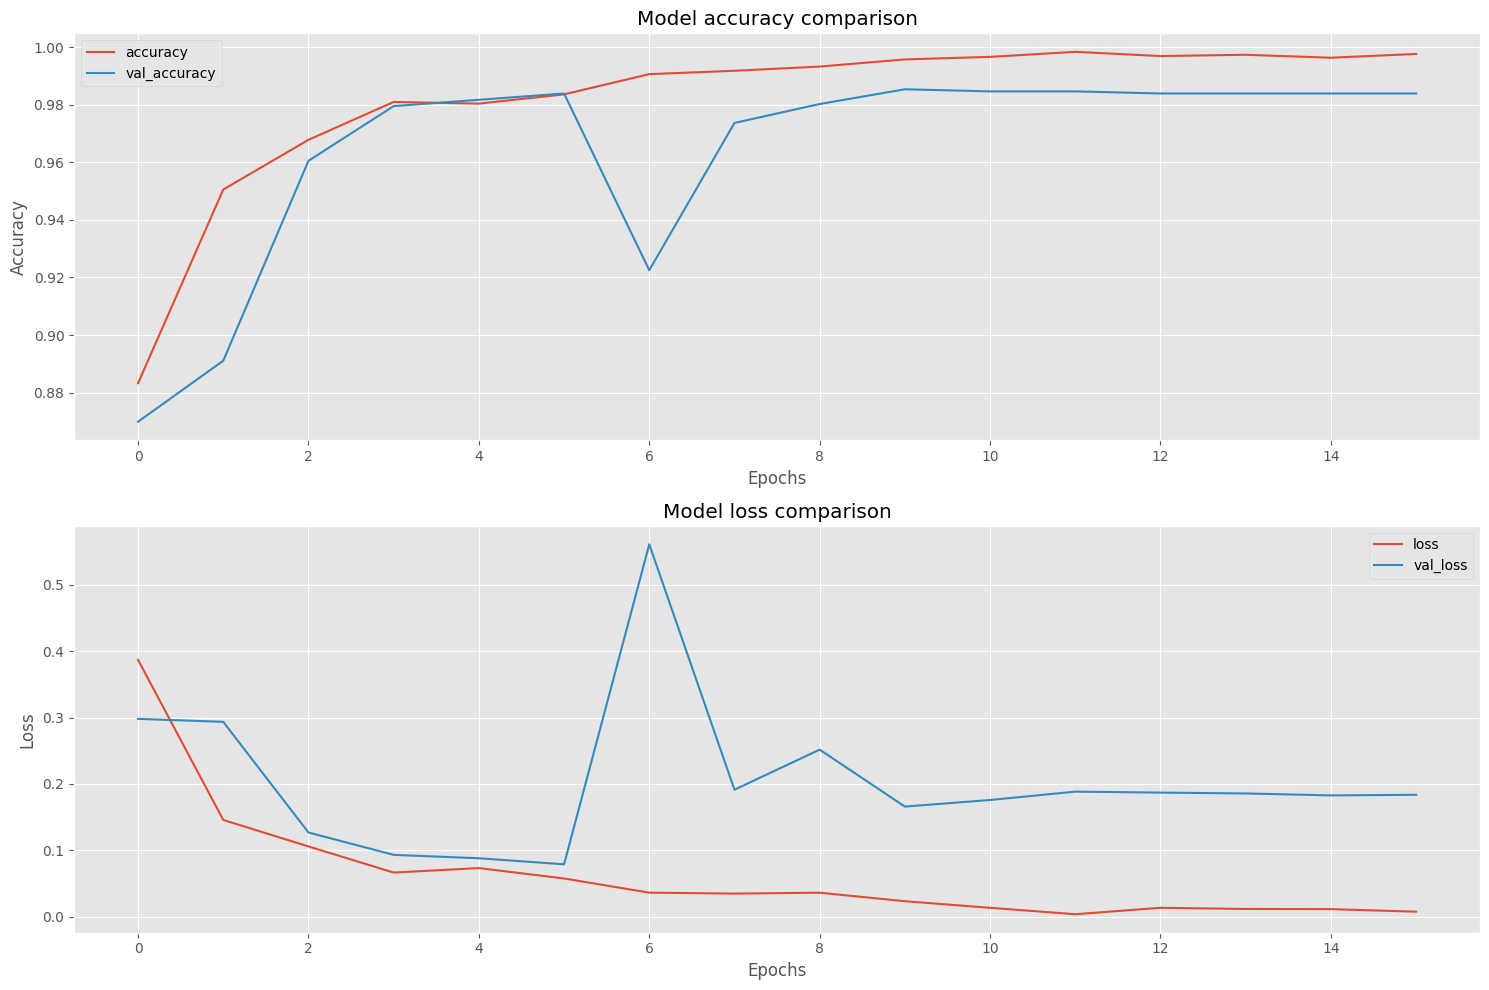

In [45]:
ModelEvaluation(resnet_finetune_history_df)

11/11 [==============================] - 6s 371ms/step

Classification Report:

               precision    recall  f1-score   support



           0       0.47      0.47      0.47       171

           1       0.46      0.46      0.46       171



    accuracy                           0.46       342

   macro avg       0.46      0.46      0.46       342

weighted avg       0.46      0.46      0.46       342




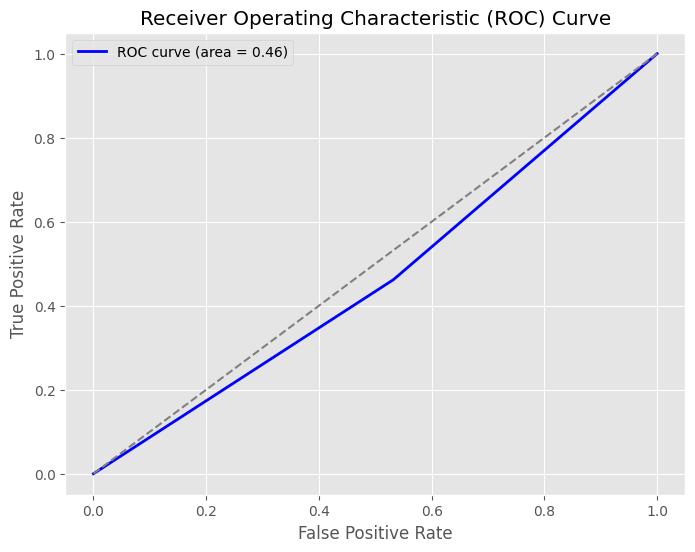

In [46]:
ModelEvaluationOnTestSet(test_data_gen, resnet_model_fine_tuned)

# MobileNetV2

In [50]:
base_model_mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=batch_x.shape[1:])

# Freeze the base model layers
for layer in base_model_mobilenet_v2.layers:
    layer.trainable = False

# Add custom top layers
x = base_model_mobilenet_v2.output
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Define the model
mobilenet_model = Model(inputs=base_model_mobilenet_v2.input, outputs=output_layer)

# Print model summary
mobilenet_model.summary()


9406464/9406464 [==============================] - 0s 0us/step

Model: "model_3"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            

                                                                                                  

 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             

                                                                                                  

 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               

 on)                                                                                              

                                                                                                  

 Conv1_relu (ReL

In [51]:
mobilenet_model.compile(loss=losses.BinaryCrossentropy(),
                        optimizer=optimizers.RMSprop(learning_rate=0.001),
                        metrics=['accuracy'])

In [53]:
train_gen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input, horizontal_flip=True)
test_and_val_gen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)


train_data_gen = train_gen.flow_from_dataframe(train,
                                               x_col="image_link",
                                               y_col="image_class",
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               class_mode="binary")

val_data_gen = test_and_val_gen.flow_from_dataframe(val,
                                                    x_col="image_link",
                                                    y_col="image_class",
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode="binary")

test_data_gen = test_and_val_gen.flow_from_dataframe(test,
                                                     x_col="image_link",
                                                     y_col="image_class",
                                                     color_mode='rgb',
                                                     target_size=(224, 224),
                                                     class_mode="binary")

Found 6836 validated image filenames belonging to 2 classes.

Found 1368 validated image filenames belonging to 2 classes.

Found 342 validated image filenames belonging to 2 classes.


In [54]:
mobilenet_history = mobilenet_model.fit(train_data_gen,
                                        validation_data=val_data_gen,
                                        batch_size=64,
                                        callbacks=[callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                                                   callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.1)],
                                        epochs=20)

Epoch 1/20

214/214 [==============================] - 139s 614ms/step - loss: 0.2190 - accuracy: 0.9222 - val_loss: 0.1535 - val_accuracy: 0.9444 - lr: 0.0010

Epoch 2/20

214/214 [==============================] - 119s 556ms/step - loss: 0.1315 - accuracy: 0.9506 - val_loss: 0.1319 - val_accuracy: 0.9496 - lr: 0.0010

Epoch 3/20

214/214 [==============================] - 99s 462ms/step - loss: 0.1199 - accuracy: 0.9567 - val_loss: 0.1199 - val_accuracy: 0.9547 - lr: 0.0010

Epoch 4/20

214/214 [==============================] - 94s 441ms/step - loss: 0.1082 - accuracy: 0.9593 - val_loss: 0.1179 - val_accuracy: 0.9532 - lr: 0.0010

Epoch 5/20

214/214 [==============================] - 95s 445ms/step - loss: 0.1024 - accuracy: 0.9623 - val_loss: 0.1089 - val_accuracy: 0.9583 - lr: 0.0010

Epoch 6/20

214/214 [==============================] - 98s 458ms/step - loss: 0.0972 - accuracy: 0.9640 - val_loss: 0.1095 - val_accuracy: 0.9627 - lr: 0.0010

Epoch 7/20

214/214 [=================

In [55]:
mobielnet_history_df = pd.DataFrame(mobilenet_history.history)

mobielnet_history_df

loss  accuracy  val_loss  val_accuracy     lr
0   0.218969  0.922177  0.153530      0.944444  0.001
1   0.131515  0.950556  0.131888      0.949561  0.001
2   0.119896  0.956700  0.119923      0.954678  0.001
3   0.108250  0.959333  0.117876      0.953216  0.001
4   0.102422  0.962259  0.108866      0.958333  0.001
5   0.097218  0.964014  0.109481      0.962719  0.001
6   0.090334  0.967964  0.104499      0.960526  0.001
7   0.090312  0.967379  0.100302      0.958333  0.001
8   0.085398  0.970304  0.100202      0.956871  0.001
9   0.080592  0.971182  0.096050      0.961988  0.001
10  0.079113  0.974693  0.097246      0.964912  0.001
11  0.077843  0.972352  0.094778      0.959064  0.001
12  0.073604  0.974839  0.091610      0.961988  0.001
13  0.074458  0.974839  0.091739      0.965643  0.001
14  0.070419  0.976302  0.089070      0.964181  0.001
15  0.071444  0.975863  0.087928      0.964912  0.001
16  0.067785  0.976887  0.088941      0.964912  0.001
17  0.065752  0.977180  0.091274      0.967836  0.001
18  0.067229  0.977180  0.085043      0.969298  0.001
19  0.064567  0.980105  0.090023      0.960526  0.001

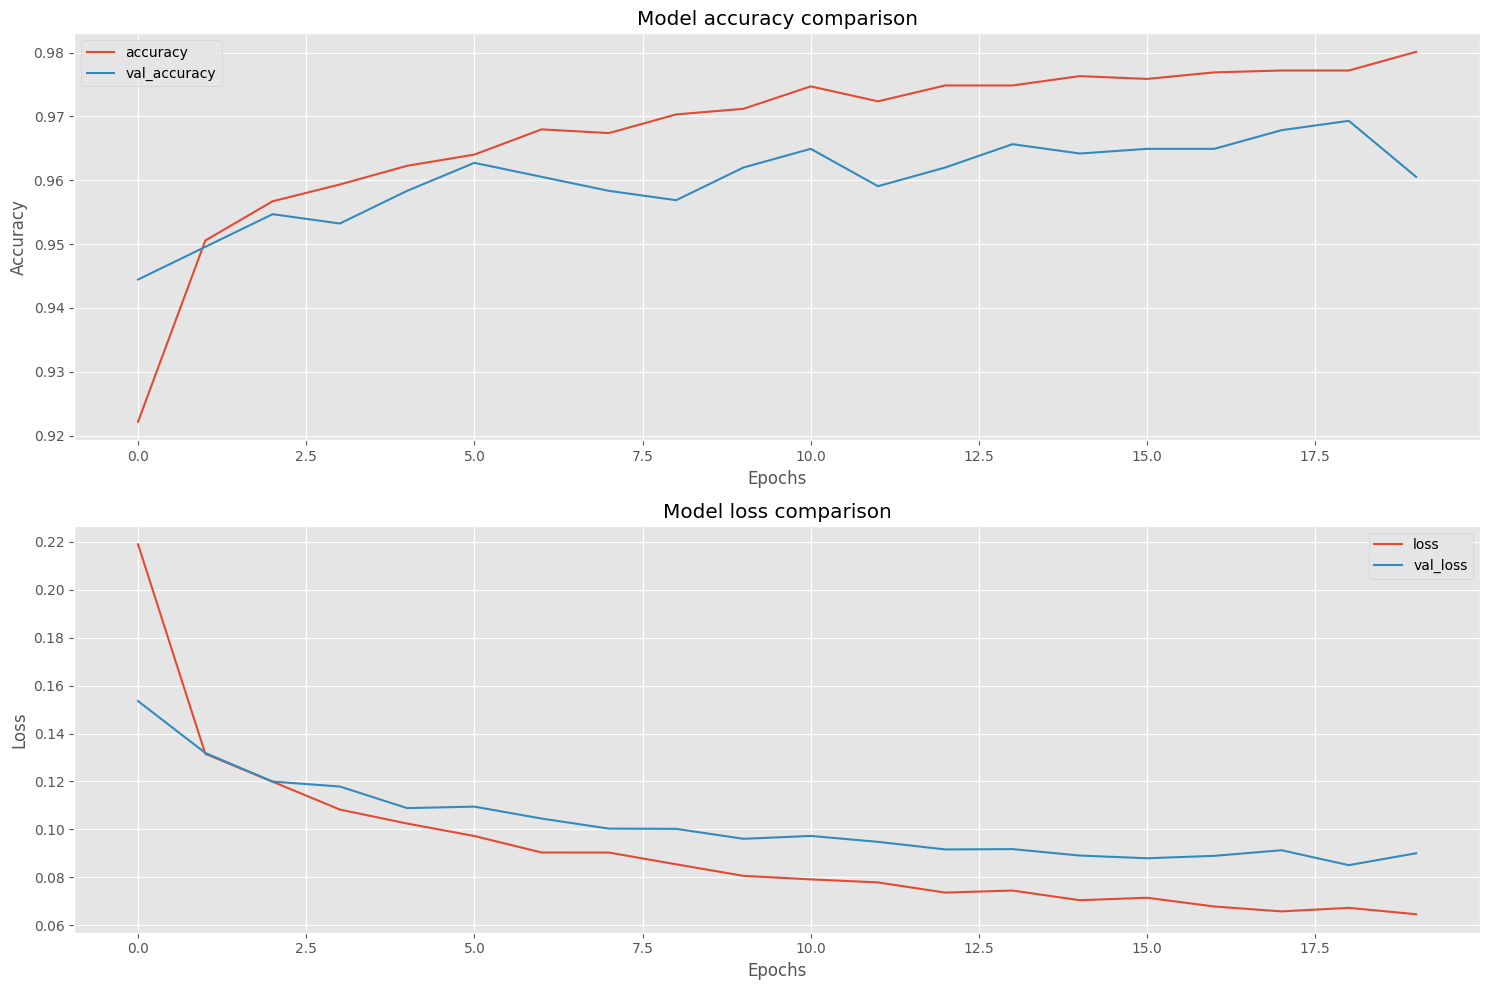

In [56]:
ModelEvaluation(mobielnet_history_df)

11/11 [==============================] - 5s 440ms/step

Classification Report:

               precision    recall  f1-score   support



           0       0.52      0.51      0.52       171

           1       0.52      0.53      0.53       171



    accuracy                           0.52       342

   macro avg       0.52      0.52      0.52       342

weighted avg       0.52      0.52      0.52       342




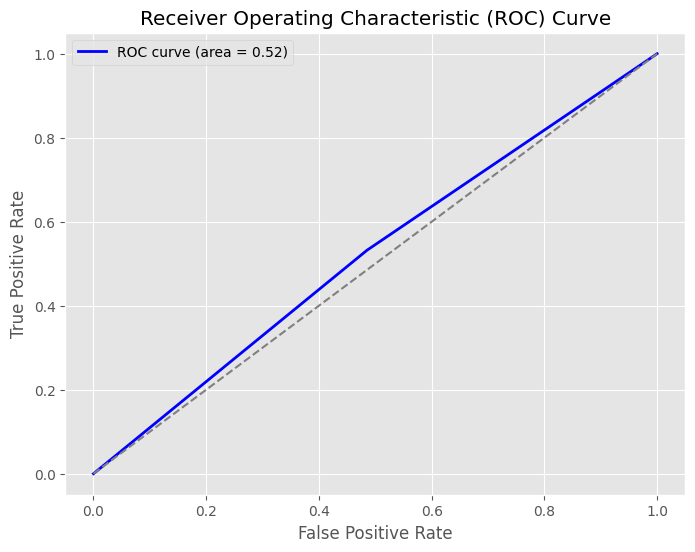

In [57]:
ModelEvaluationOnTestSet(test_data_gen, mobilenet_model)

# FastAI

In [69]:
from fastai.vision.all import *

In [38]:
xtrain, xval, ytrain, yval = train_test_split(X_up, y_up, test_size=.2, random_state=42, stratify=y_up)
xval, xtest, yval, ytest = train_test_split(xval, yval, test_size=.2, random_state=42, stratify=yval)

train = pd.concat([xtrain, ytrain], axis="columns").reset_index(drop=True)
val = pd.concat([xval, yval], axis="columns").reset_index(drop=True)
test_ = pd.concat([xtest, ytest], axis="columns").reset_index(drop=True)

print(f"Training size: {train.shape}")
print(f"Validation size: {val.shape}")
print(f"Test size: {test_.shape}")

Training size: (6836, 2)
Validation size: (1368, 2)
Test size: (342, 2)


In [19]:
total_df_train = pd.concat([train, val], axis="rows")

total_df_train

image_link  \
0      /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person337_bacteria_1561.jpeg   
1              /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1_virus_12.jpeg   
2            /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg   
3                    /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0505-0001.jpeg   
4              /kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg   
...                                                                                           ...   
1363                 /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0695-0001.jpeg   
1364  /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1701_bacteria_4504.jpeg   
1365          /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0307-0001.jpeg   
1366         /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1104-0001.jpeg   
1367  /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1512_bacteria_3958.jpeg   

     image_class  
0      PNEUMONIA  
1      PNEUMONIA  
2         NORMAL  
3         NORMAL  
4         NORMAL  
...          ...  
1363      NORMAL  
1364   PNEUMONIA  
1365      NORMAL  
1366      NORMAL  
1367   PNEUMONIA  

[8204 rows x 2 columns]

In [20]:
fastai_dataloader = ImageDataLoaders.from_df(total_df_train,
                                             path="/", # '/' mean root directory why '.' means current working directory
                                             x_col="image_link",
                                             y_col="image_class",
                                             valid_pct=0.2,
                                             item_tfms=Resize(224),
                                             batch_tfms=aug_transforms(),
                                             shuffle=True)

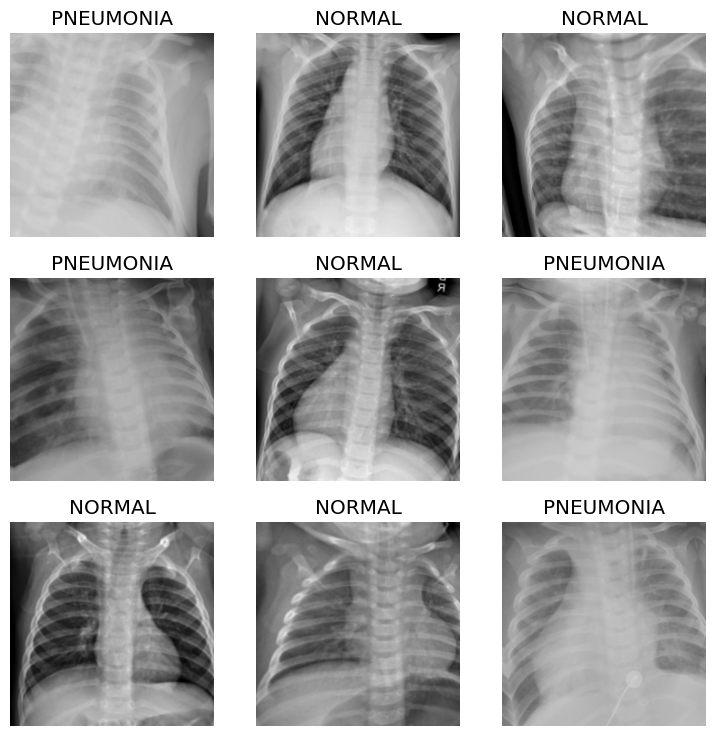

In [21]:
fastai_dataloader.train.show_batch()

In [22]:
learner = vision_learner(dls=fastai_dataloader,
                         arch=resnet50,
                         metrics=[accuracy, error_rate])

SuggestedLRs(valley=0.0008317637839354575)

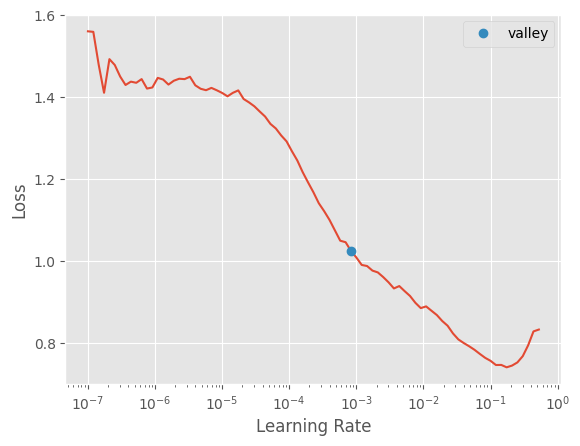

In [23]:
learner.lr_find()

In [24]:
learner.fine_tune(epochs=20, base_lr=0.0008317637839354575)

In [32]:
interpreter = ClassificationInterpretation.from_learner(learner)

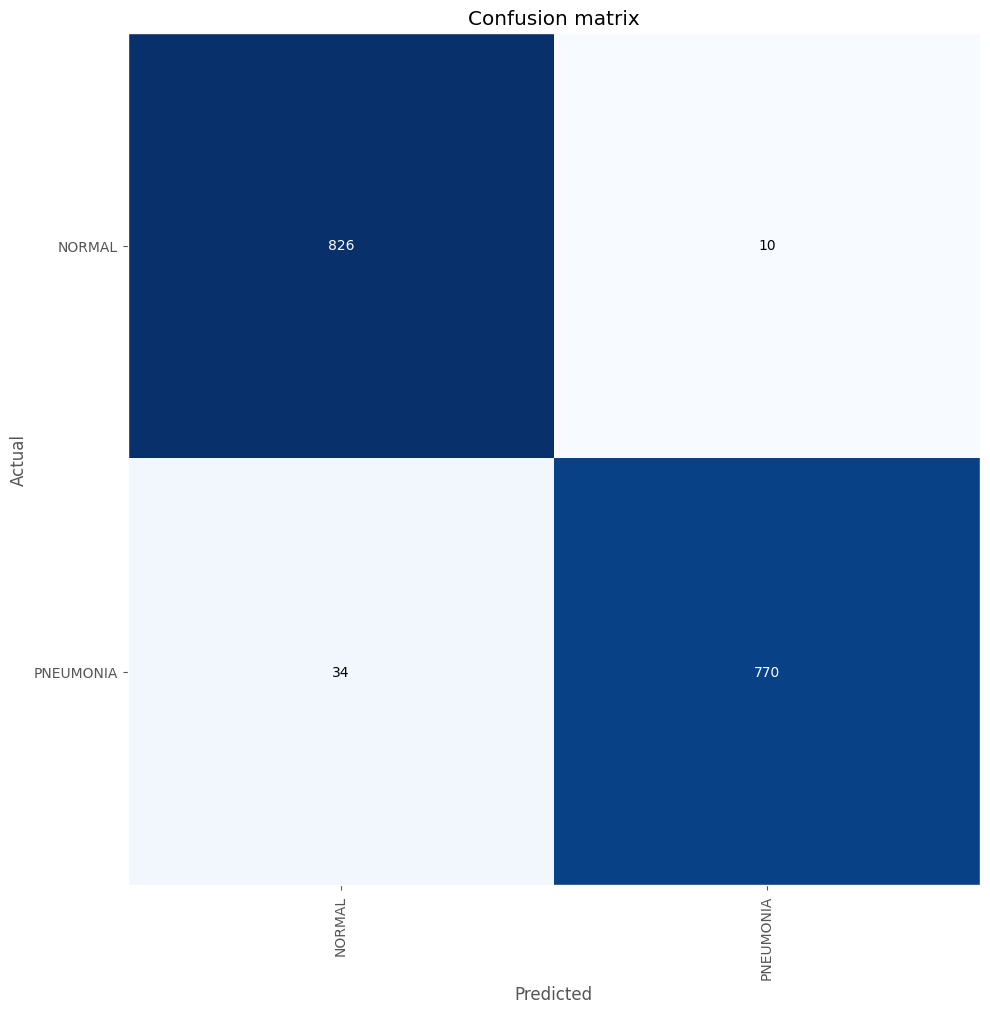

In [34]:
interpreter.plot_confusion_matrix(figsize=(20, 10))

In [35]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.96      0.99      0.97       836
   PNEUMONIA       0.99      0.96      0.97       804

    accuracy                           0.97      1640
   macro avg       0.97      0.97      0.97      1640
weighted avg       0.97      0.97      0.97      1640



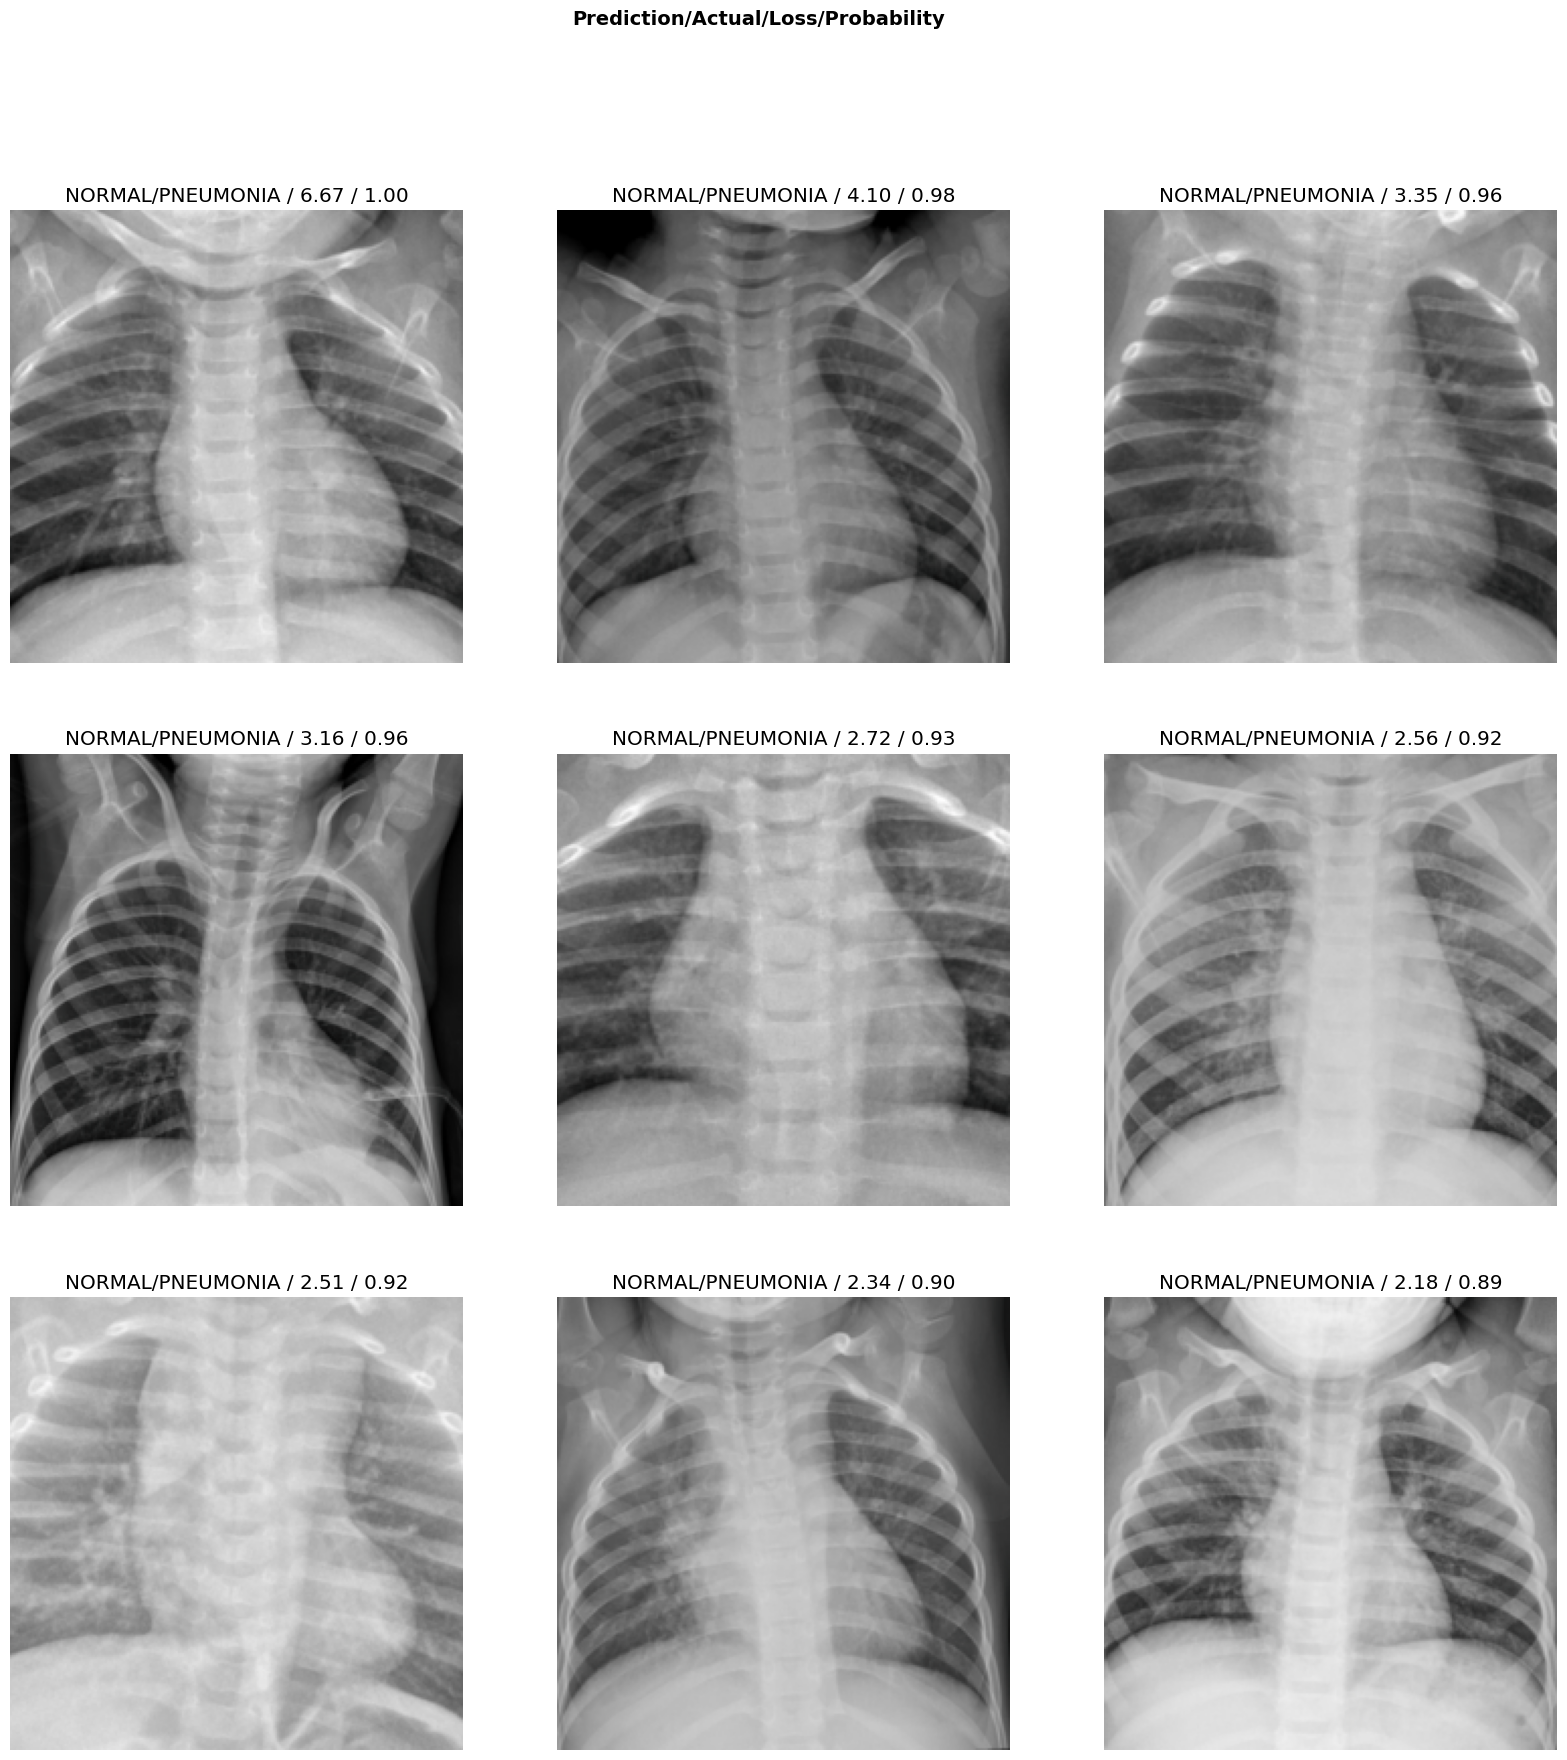

In [36]:
interpreter.plot_top_losses(k=9, figsize=(20, 20))

In [39]:
test_

image_link  \
0    /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1320_bacteria_3342.jpeg   
1           /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person49_virus_101.jpeg   
2     /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person399_bacteria_1804.jpeg   
3           /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1028-0001.jpeg   
4                   /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0656-0001.jpeg   
..                                                                                           ...   
337                 /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0365-0001.jpeg   
338  /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1111_bacteria_3052.jpeg   
339          /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg   
340     /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1164_virus_1955.jpeg   
341  /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1922_bacteria_4830.jpeg   

    image_class  
0     PNEUMONIA  
1     PNEUMONIA  
2     PNEUMONIA  
3        NORMAL  
4        NORMAL  
..          ...  
337      NORMAL  
338   PNEUMONIA  
339      NORMAL  
340   PNEUMONIA  
341   PNEUMONIA  

[342 rows x 2 columns]

In [40]:
fastai_test_dataloader = ImageDataLoaders.from_df(test_,
                                                  path="/", # '/' mean root directory why '.' means current working directory
                                                  x_col="image_link",
                                                  y_col="image_class",
                                                  item_tfms=Resize(224),
                                                  batch_tfms=aug_transforms(),
                                                  shuffle=False)

In [44]:
test_preds, test_y = learner.get_preds(dl=fastai_test_dataloader)

print(test_preds, test_y)

tensor([[1.6115e-05, 9.9998e-01],
        [7.2449e-06, 9.9999e-01],
        [1.2139e-05, 9.9999e-01],
        [3.3501e-06, 1.0000e+00],
        [9.9194e-06, 9.9999e-01],
        [8.0383e-06, 9.9999e-01],
        [5.8610e-06, 9.9999e-01],
        [1.5120e-05, 9.9998e-01],
        [8.0125e-06, 9.9999e-01],
        [4.1713e-06, 1.0000e+00],
        [3.7681e-06, 1.0000e+00],
        [5.0477e-05, 9.9995e-01],
        [6.6294e-05, 9.9993e-01],
        [3.6714e-05, 9.9996e-01],
        [8.2219e-06, 9.9999e-01],
        [9.8271e-06, 9.9999e-01],
        [1.8443e-05, 9.9998e-01],
        [5.8108e-06, 9.9999e-01],
        [1.1157e-05, 9.9999e-01],
        [2.6079e-05, 9.9997e-01],
        [8.9317e-06, 9.9999e-01],
        [1.3822e-05, 9.9999e-01],
        [1.9468e-05, 9.9998e-01],
        [1.6939e-05, 9.9998e-01],
        [7.2349e-06, 9.9999e-01],
        [8.9855e-06, 9.9999e-01],
        [3.5929e-05, 9.9996e-01],
        [1.6843e-05, 9.9998e-01],
        [3.6931e-06, 1.0000e+00],
        [1.642

In [62]:
def Plot_ROC_Curve_and_Confusion_Matrix(y_true, y_pred):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  
    roc_auc = auc(fpr, tpr)
    
    y_pred_class = np.argmax(y_pred, axis=1)  # Get the class with highest probability
    
    print(classification_report(y_true, y_pred_class))
    
    # Plot ROC curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)  # ROC Curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_class)
    
    # Plot confusion matrix
    plt.subplot(1, 2, 2)  # Confusion Matrix
    sns.heatmap(cm, annot=True, xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.49      1.00      0.65       133

    accuracy                           0.49       274
   macro avg       0.24      0.50      0.33       274
weighted avg       0.24      0.49      0.32       274



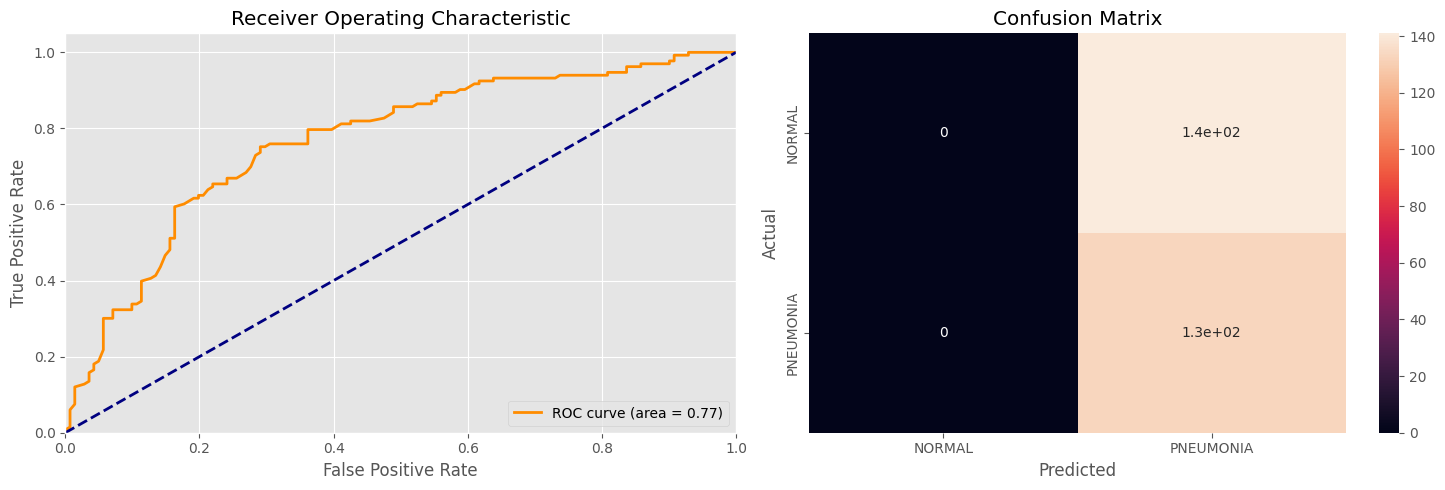

In [63]:
Plot_ROC_Curve_and_Confusion_Matrix(test_y, test_preds)

# Data Augmentation

In [70]:
fastai_dataloader = ImageDataLoaders.from_df(total_df_train,
                                             path="/", # '/' mean root directory why '.' means current working directory
                                             x_col="image_link",
                                             y_col="image_class",
                                             valid_pct=0.2,
                                             item_tfms=Resize(224),
                                             batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()],
                                             shuffle=True)

In [71]:
learner = vision_learner(dls=fastai_dataloader,
                         arch=resnet50,
                         metrics=[accuracy, error_rate])

SuggestedLRs(valley=0.0006918309954926372)

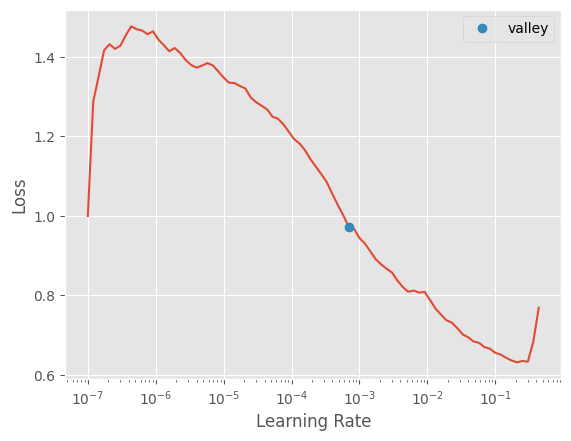

In [72]:
learner.lr_find()

In [73]:
learner.fine_tune(epochs=30, base_lr=0.0006918309954926372)

In [88]:
interpreter = ClassificationInterpretation.from_learner(learner)

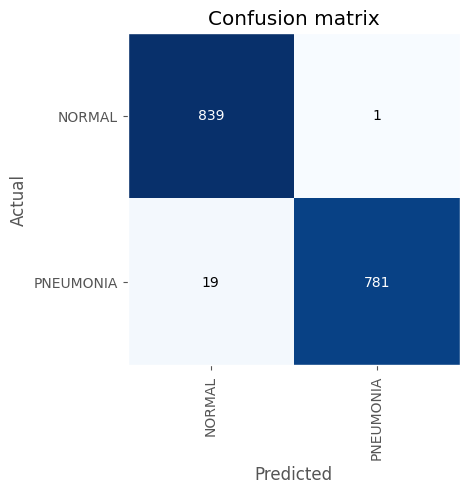

In [89]:
interpreter.plot_confusion_matrix()

In [90]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.98      1.00      0.99       840
   PNEUMONIA       1.00      0.98      0.99       800

    accuracy                           0.99      1640
   macro avg       0.99      0.99      0.99      1640
weighted avg       0.99      0.99      0.99      1640



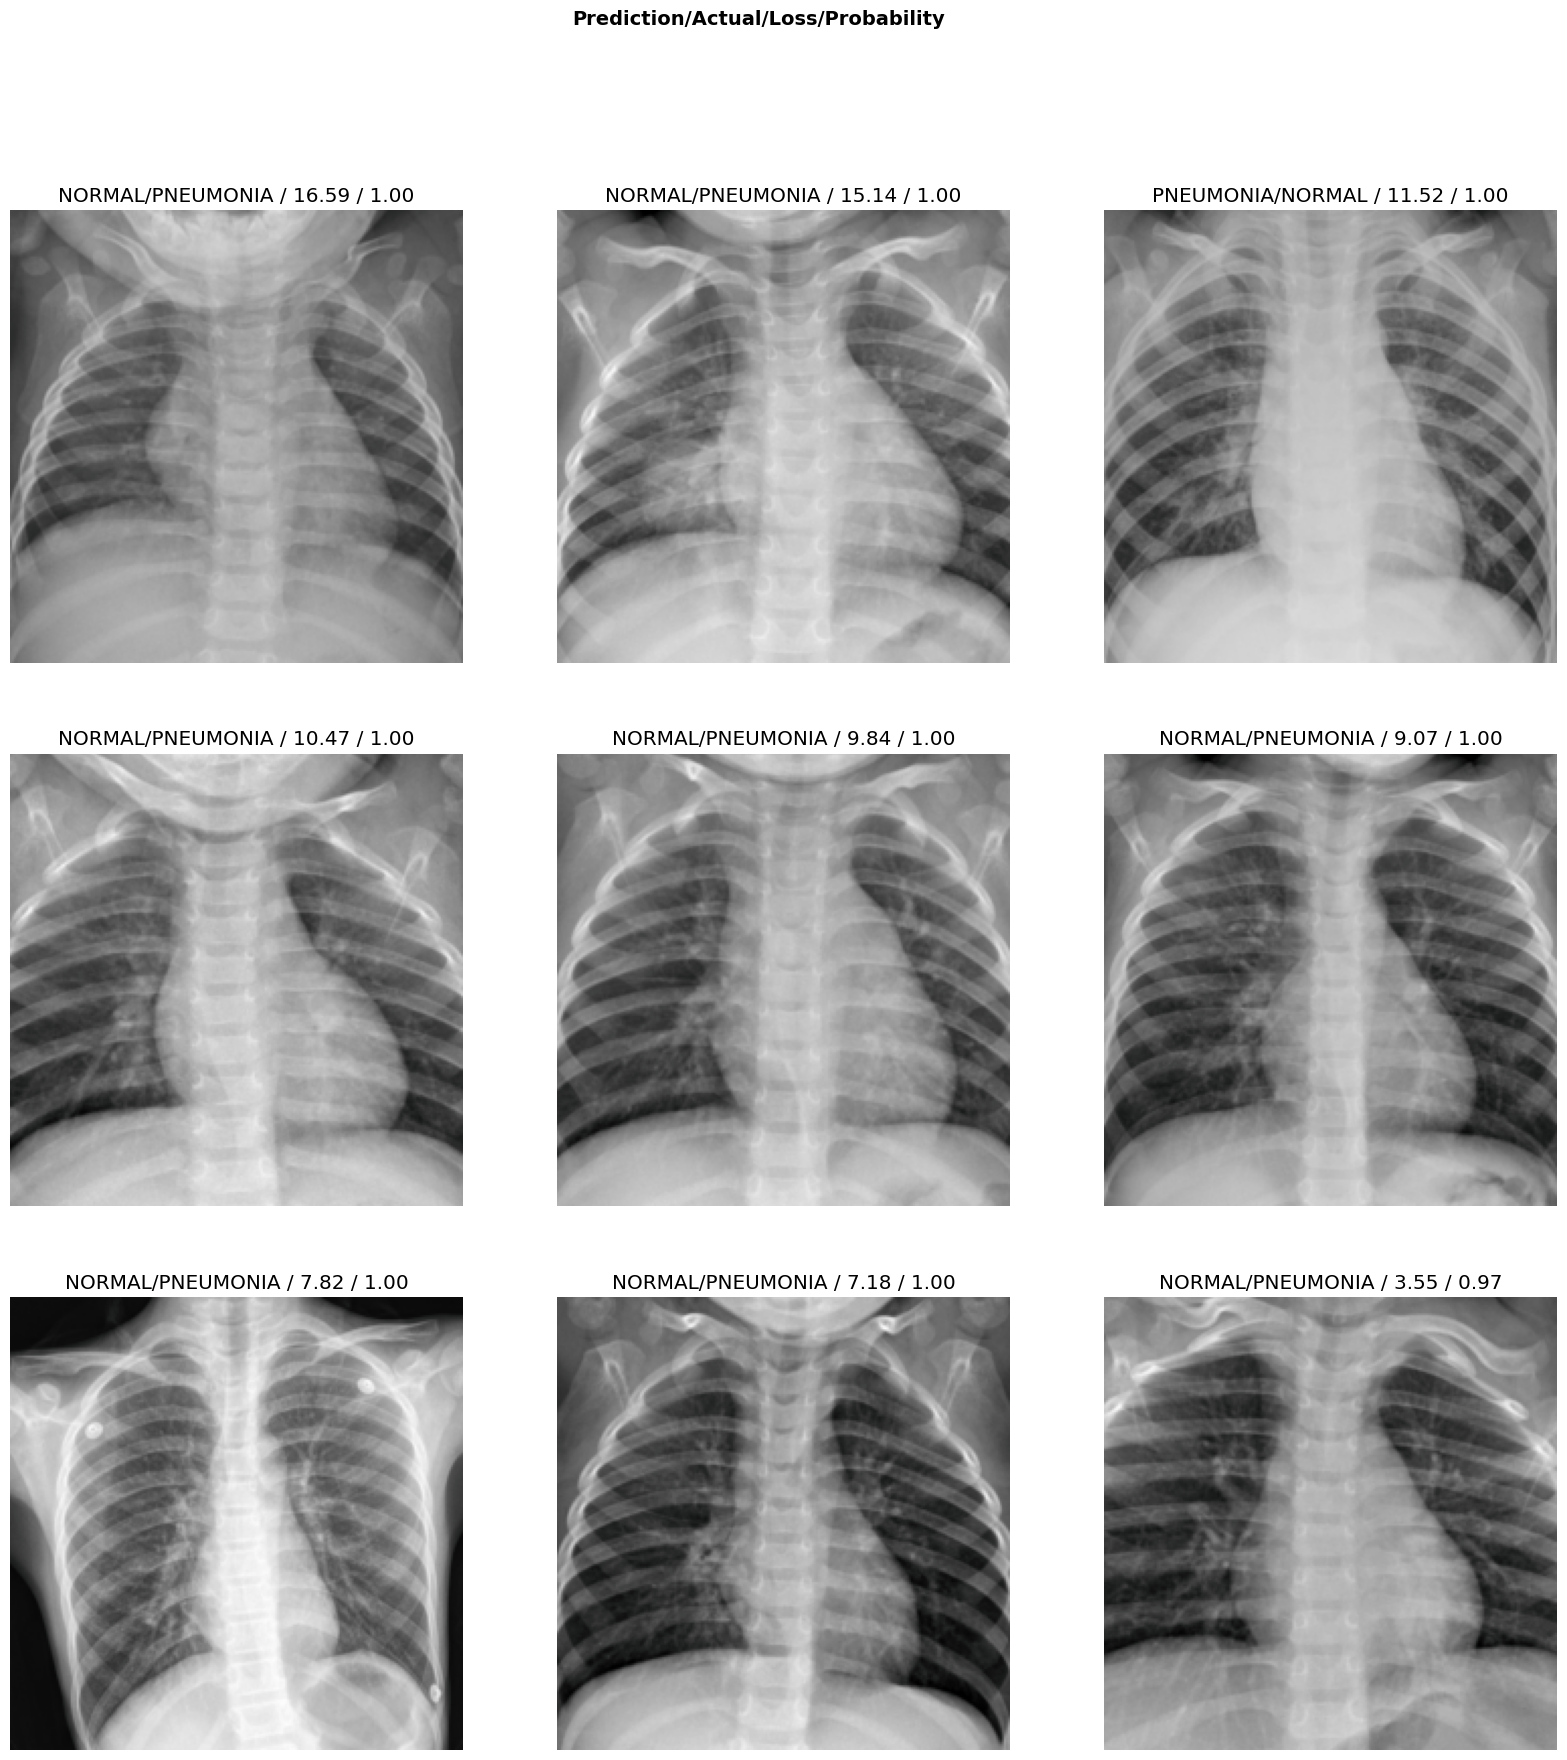

In [91]:
interpreter.plot_top_losses(k=9, figsize=(20, 20))

In [92]:
test_preds, test_y = learner.get_preds(dl=fastai_test_dataloader)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.49      1.00      0.65       133

    accuracy                           0.49       274
   macro avg       0.24      0.50      0.33       274
weighted avg       0.24      0.49      0.32       274



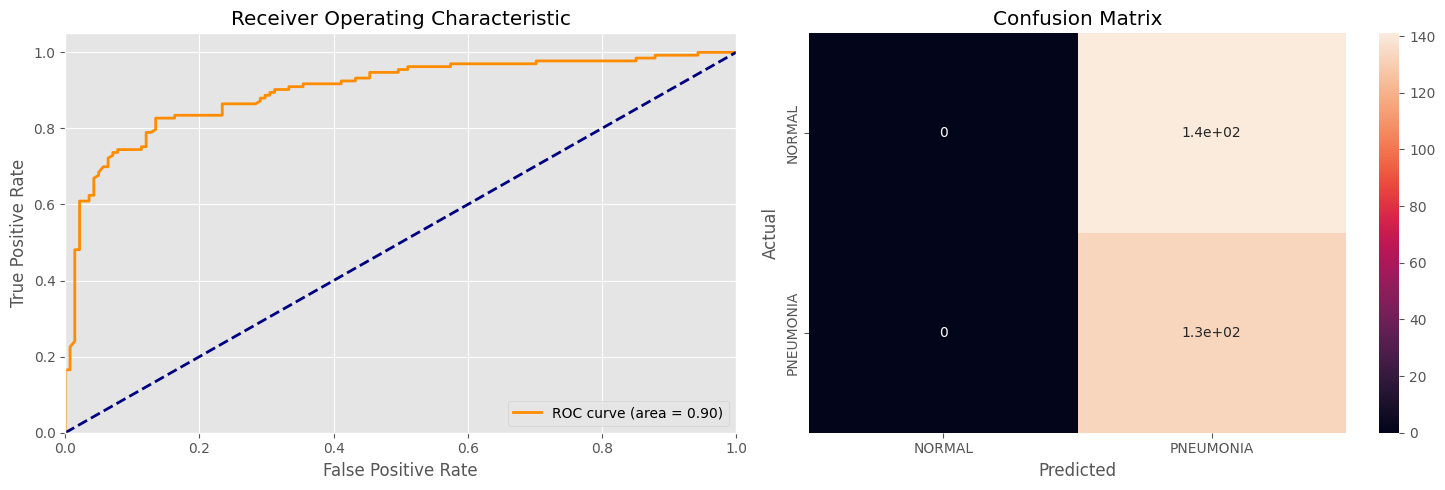

In [93]:
Plot_ROC_Curve_and_Confusion_Matrix(test_y, test_preds)